# 数据加载

In [90]:
import os, glob
from pathlib import Path
import matplotlib
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.text as mtext
from matplotlib.font_manager import FontProperties

# 0) 清掉历史 rcParams 污染（可选但推荐）
mpl.rcParams.update(mpl.rcParamsDefault)

# 1) 注册 macOS 宋体 + 清理字体缓存（第一次设置建议做）
cache_dir = matplotlib.get_cachedir()
for f in glob.glob(os.path.join(cache_dir, "fontlist-*.json")):
    try:
        os.remove(f)
    except Exception:
        pass

songti_path = "/System/Library/Fonts/Supplemental/Songti.ttc"
if Path(songti_path).exists():
    try:
        fm.fontManager.addfont(songti_path)
    except Exception:
        pass

# 2) 全局默认字体先指向宋体（不要再把 sans-serif 写成 Times New Roman）
mpl.rcParams["axes.unicode_minus"] = False
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Songti SC", "Heiti SC", "DejaVu Sans"]
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

# 3) 关键：安装 draw hook —— 每次渲染前，把“含中文的 Text”强制切到宋体
def _has_cn(s: str) -> bool:
    return any("\u4e00" <= ch <= "\u9fff" for ch in s)

_fp_cn = FontProperties(family="Songti SC", weight="normal")

# idempotent：重复运行不会叠加/递归
from matplotlib.backends.backend_agg import FigureCanvasAgg
if not hasattr(FigureCanvasAgg, "_songti_hook_installed"):
    FigureCanvasAgg._songti_hook_installed = True
    FigureCanvasAgg._orig_draw = FigureCanvasAgg.draw

    def _draw_with_songti(self, *args, **kwargs):
        fig = getattr(self, "figure", None)
        if fig is not None:
            for t in fig.findobj(mtext.Text):
                s = t.get_text()
                if s and _has_cn(s):
                    t.set_fontproperties(_fp_cn)
        return FigureCanvasAgg._orig_draw(self, *args, **kwargs)

    FigureCanvasAgg.draw = _draw_with_songti

print("✅ 已启用：全局中文强制 Songti SC（宋体），无需每个单元格修改")


✅ 已启用：全局中文强制 Songti SC（宋体），无需每个单元格修改


In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

SEED = 42
df = pd.read_excel('CEML2原始数据.xlsx')
df.head(500)


,Age,Sex,PVA,BCVA,PreIOP,HOS,DM,HbA1c,HTN,TG,...,Chamber Angle,TOT,Average Vacuum,Vacuum Time,US AVE,U/S APT,EPT,IFU,CDE,CTS
0,78,1,1.00,1.00,18,0,1,7.0,1,2.40,...,21.1,659,269.9,178.7,5,78.30,3.91,111,19.55,0
1,35,1,0.70,0.70,13,0,0,0.0,0,5.14,...,34.3,648,276.8,151.5,2,23.44,0.51,74,1.02,0
2,60,0,0.52,0.52,21,0,0,0.0,0,2.06,...,30.9,656,158.4,134.0,10,55.49,5.93,72,59.30,0
3,55,1,1.90,1.90,21,0,0,0.0,0,0.98,...,31.5,762,195.3,150.0,15,75.59,11.41,86,171.15,1
4,69,0,2.30,2.20,18,0,0,0.0,0,4.06,...,30.2,1116,306.4,355.9,4,58.46,2.39,148,9.56,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,69,1,0.52,0.52,22,0,0,0.0,0,1.09,...,32.0,624,251.5,170.8,7,44.27,3.23,91,22.61,0
303,64,0,0.22,0.00,17,0,0,0.0,1,2.09,...,22.4,523,273.8,137.6,1,25.10,0.45,91,0.45,0
304,56,0,1.85,0.92,18,0,0,0.0,0,0.60,...,35.1,552,296.1,131.0,11,54.84,6.25,87,68.75,0
305,71,0,1.22,1.00,20,0,0,0.0,0,1.01,...,32.4,698,235.7,208.2,17,126.08,22.19,99,377.23,1


# 查看缺失值

In [92]:
# # 查看数据形状（样本数、特征数）
# print("\n数据形状：", df.shape)

# 查看列名及数据类型
print("\n列信息：")
print(df.info())

# # 统计描述性统计（数值型特征）
# print("\n数值型特征统计：")
# print(df.describe())


列信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             307 non-null    int64  
 1   Sex             307 non-null    int64  
 2   PVA             307 non-null    float64
 3   BCVA            307 non-null    float64
 4   PreIOP          307 non-null    int64  
 5   HOS             307 non-null    int64  
 6   DM              307 non-null    int64  
 7   HbA1c           307 non-null    float64
 8   HTN             307 non-null    int64  
 9   TG              307 non-null    float64
 10  TC              307 non-null    float64
 11  HDL             307 non-null    float64
 12  LDL             307 non-null    float64
 13  NUM             307 non-null    int64  
 14  CD              307 non-null    int64  
 15  AVG             307 non-null    int64  
 16  SD              307 non-null    int64  
 17  CV              307 non-null 

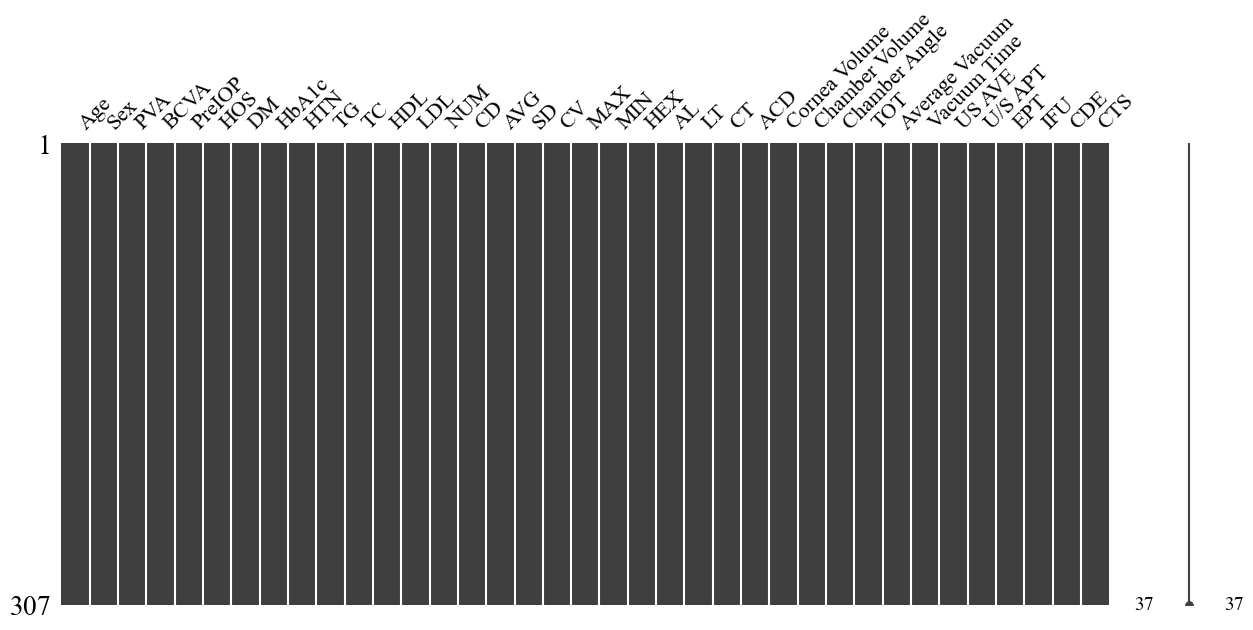

已保存： /Users/mac/PycharmProjects/CE-prediction model /missing_matrix.png
已保存： /Users/mac/PycharmProjects/CE-prediction model /missing_matrix.pdf


In [93]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['font.size'] = 10.5

# ---- missingno 绘图 ----
import missingno as msno

ax = msno.matrix(df, figsize=(15, 6))
ax.set_title('', fontsize=12)

# 关键：拿到 figure 来保存
fig = ax.figure

# 保存路径（当前工作目录下）
out_png = "missing_matrix.png"
out_pdf = "missing_matrix.pdf"

fig.savefig(out_png, dpi=300, bbox_inches='tight')
fig.savefig(out_pdf, bbox_inches='tight')

plt.show()

print("已保存：", os.path.abspath(out_png))
print("已保存：", os.path.abspath(out_pdf))

# 填充缺失值

In [94]:
import pandas as pd
from sklearn.impute import SimpleImputer

# 1. 识别缺失列
missing_cols = df.columns[df.isnull().any()].tolist()

# 2. 中位数填充（适用于连续数值型特征）
imputer = SimpleImputer(strategy='median')
df[missing_cols] = imputer.fit_transform(df[missing_cols])

# 3. 验证填充结果
print("填充后各列缺失值数量：")
print(df.isnull().sum())

ValueError: at least one array or dtype is required

In [95]:
df.head()

,Age,Sex,PVA,BCVA,PreIOP,HOS,DM,HbA1c,HTN,TG,...,Chamber Angle,TOT,Average Vacuum,Vacuum Time,US AVE,U/S APT,EPT,IFU,CDE,CTS
0,78,1,1.00,1.00,18,0,1,7.0,1,2.40,...,21.1,659,269.9,178.7,5,78.30,3.91,111,19.55,0
1,35,1,0.70,0.70,13,0,0,0.0,0,5.14,...,34.3,648,276.8,151.5,2,23.44,0.51,74,1.02,0
2,60,0,0.52,0.52,21,0,0,0.0,0,2.06,...,30.9,656,158.4,134.0,10,55.49,5.93,72,59.30,0
3,55,1,1.90,1.90,21,0,0,0.0,0,0.98,...,31.5,762,195.3,150.0,15,75.59,11.41,86,171.15,1
4,69,0,2.30,2.20,18,0,0,0.0,0,4.06,...,30.2,1116,306.4,355.9,4,58.46,2.39,148,9.56,1


# 划分数据集X和Y

In [96]:
# 分离特征和目标变量
X = df.drop('CTS', axis=1)  # 获取特征
y = df['CTS']  # 获取目标变量 

# 打印 X 和 y 的前几行以验证结果
print("Features (X):")
X

Features (X):


,Age,Sex,PVA,BCVA,PreIOP,HOS,DM,HbA1c,HTN,TG,...,Chamber Volume,Chamber Angle,TOT,Average Vacuum,Vacuum Time,US AVE,U/S APT,EPT,IFU,CDE
0,78,1,1.00,1.00,18,0,1,7.0,1,2.40,...,91.0,21.1,659,269.9,178.7,5,78.30,3.91,111,19.55
1,35,1,0.70,0.70,13,0,0,0.0,0,5.14,...,116.0,34.3,648,276.8,151.5,2,23.44,0.51,74,1.02
2,60,0,0.52,0.52,21,0,0,0.0,0,2.06,...,103.0,30.9,656,158.4,134.0,10,55.49,5.93,72,59.30
3,55,1,1.90,1.90,21,0,0,0.0,0,0.98,...,146.0,31.5,762,195.3,150.0,15,75.59,11.41,86,171.15
4,69,0,2.30,2.20,18,0,0,0.0,0,4.06,...,86.0,30.2,1116,306.4,355.9,4,58.46,2.39,148,9.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,69,1,0.52,0.52,22,0,0,0.0,0,1.09,...,114.0,32.0,624,251.5,170.8,7,44.27,3.23,91,22.61
303,64,0,0.22,0.00,17,0,0,0.0,1,2.09,...,95.0,22.4,523,273.8,137.6,1,25.10,0.45,91,0.45
304,56,0,1.85,0.92,18,0,0,0.0,0,0.60,...,155.0,35.1,552,296.1,131.0,11,54.84,6.25,87,68.75
305,71,0,1.22,1.00,20,0,0,0.0,0,1.01,...,98.0,32.4,698,235.7,208.2,17,126.08,22.19,99,377.23


# 划分训练集和测试集

In [97]:
from  sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=SEED,stratify=y)

scaler = StandardScaler()

# 展现目标变量分布

训练集类别分布：
CTS
0    164
1     81
Name: count, dtype: int64

测试集类别分布：
CTS
0    41
1    21
Name: count, dtype: int64


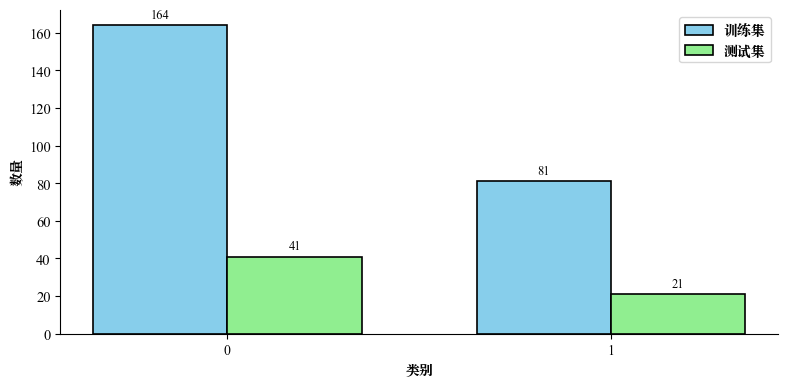

In [98]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
import pandas as pd
import chardet
import matplotlib.pyplot as plt
import matplotlib as mpl

# 设置中文字体
mpl.rcParams['font.sans-serif'] = ['Songti SC']
# 解决负号显示问题
mpl.rcParams['axes.unicode_minus'] = False

# 计算训练集、测试集的类别分布
train_distribution = y_train.value_counts().sort_index()  # 按类别排序，保证两组分布顺序一致
test_distribution = y_test.value_counts().sort_index()

print("训练集类别分布：")
print(train_distribution)
print("\n测试集类别分布：")
print(test_distribution)

# 定义颜色列表（训练集、测试集用不同色系）
train_colors = ['skyblue', 'skyblue']
test_colors = ['lightgreen', 'lightgreen']

# 绘制训练集+测试集对比柱状图
plt.figure(figsize=(8, 4))  # 适当加宽图幅，避免拥挤

# 设置x轴位置（两组柱子并排显示）
x = range(len(train_distribution))
width = 0.35  # 柱子宽度

# 绘制训练集柱状图
bars1 = plt.bar(
    [i - width/2 for i in x], train_distribution.values,
    width=width, color=train_colors[:len(train_distribution)],
    edgecolor='black', linewidth=1.2, label='训练集'
)

# 绘制测试集柱状图
bars2 = plt.bar(
    [i + width/2 for i in x], test_distribution.values,
    width=width, color=test_colors[:len(test_distribution)],
    edgecolor='black', linewidth=1.2, label='测试集'
)

# 设置图表标签和标题
plt.xlabel('类别', fontsize=10)
plt.ylabel('数量', fontsize=10)
plt.title('', fontsize=12)
plt.xticks(x, train_distribution.index.astype(str), rotation=0, fontsize=10)
plt.legend(fontsize=10)  # 显示图例，区分训练集/测试集

# 为训练集添加数据标签
for bar in bars1:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)

# 为测试集添加数据标签
for bar in bars2:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)

# 去掉上边框和右边框
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

# 保存图片
plt.savefig('训练集测试集类别分布对比图.pdf', dpi=300)
plt.show()

# ADASYN处理数据不平衡————只对训练集过采样

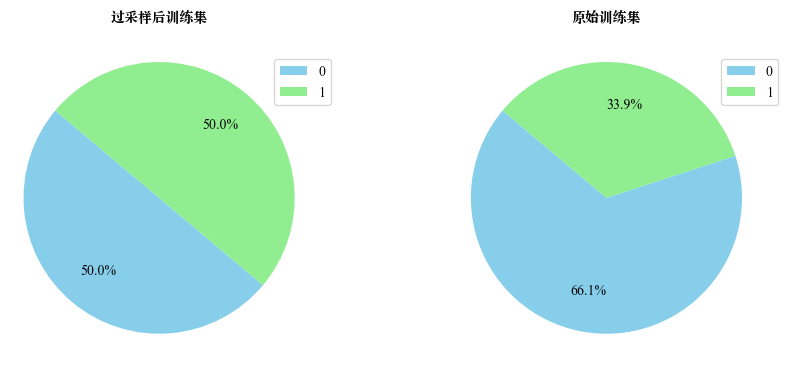

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from imblearn.over_sampling import RandomOverSampler  # 过采样工具
import numpy as np

# ---------------------- 仅对训练集执行过采样 ----------------------
oversampler = RandomOverSampler(random_state=42)  # 随机过采样
x_train_oversampled, y_train_oversampled = oversampler.fit_resample(x_train, y_train)

# ---------------------- 计算分布（过采样后训练集 + 原始测试集） ----------------------
train_oversampled_dist = pd.Series(y_train_oversampled).value_counts().sort_index()  # 过采样后训练集分布
test_original_dist = y_test.value_counts().sort_index()  # 测试集原始分布（无过采样）

# ---------------------- 绘制1×2饼图（添加子图标题） ----------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))  # 1行2列子图，总尺寸8×4
colors = ['skyblue', 'lightgreen']  # 统一颜色方案

# ---------------------- 子图1：过采样后训练集（添加标题） ----------------------
wedges1, texts1, autotexts1 = ax1.pie(
    train_oversampled_dist.values,
    colors=colors[:len(train_oversampled_dist)],
    autopct='%1.1f%%',  # 百分比保留1位小数
    startangle=140,
    pctdistance=0.7
)
ax1.set_title('过采样后训练集', fontsize=12, pad=10)  # 子图1标题，pad控制标题与饼图间距
# 训练集图例（放在子图右侧）
ax1.legend(
    wedges1, train_oversampled_dist.index.astype(str),
    bbox_to_anchor=(1.1, 0.95),
    fontsize=10,
    markerscale=1.2
)
# 设置字体大小
for text in texts1:
    text.set_fontsize(10)
for autotext in autotexts1:
    autotext.set_fontsize(10)
ax1.axis('equal')  # 保证饼图为正圆形

# ---------------------- 子图2：原始测试集 ----------------------
wedges2, texts2, autotexts2 = ax2.pie(
    test_original_dist.values,
    colors=colors[:len(test_original_dist)],
    autopct='%1.1f%%',
    startangle=140,
    pctdistance=0.7
)
ax2.set_title('原始训练集', fontsize=12, pad=10)  # 子图2标题，与子图1风格一致
# 测试集图例（放在子图右侧）
ax2.legend(
    wedges2, test_original_dist.index.astype(str),
    bbox_to_anchor=(1.1, 0.95),
    fontsize=10,
    markerscale=1.2
)
# 设置字体大小
for text in texts2:
    text.set_fontsize(10)
for autotext in autotexts2:
    autotext.set_fontsize(10)
ax2.axis('equal')  # 保证饼图为正圆形

# ---------------------- 布局调整 ----------------------
plt.tight_layout()  # 自动调整子图间距
plt.subplots_adjust(wspace=0.5, top=0.85)  # 增加水平间距+顶部空间
# 子图标题，与子图1风格一致
# 测试集图例（放在子图右侧）
ax2.legend(
    wedges2, test_original_dist.index.astype(str),
    bbox_to_anchor=(1.1, 0.95),
    fontsize=10,
    markerscale=1.2
)
# 设置字体大小
for text in texts2:
    text.set_fontsize(10)
for autotext in autotexts2:
    autotext.set_fontsize(10)
ax2.axis('equal')  # 保证饼图为正圆形

# ---------------------- 布局调整 ----------------------
plt.tight_layout()  # 自动调整子图间距
plt.subplots_adjust(wspace=0.5, top=0.85)  # 增加水平间距+顶部空间，适配标题

# ---------------------- 保存与显示 ----------------------
plt.savefig('oversampled_train_test_distribution_pie.pdf', dpi=300, bbox_inches='tight')  # bbox_inches避免图例/标题裁剪
plt.show()

In [100]:
x_train = x_train_oversampled
y_train = y_train_oversampled

In [101]:
print("过采样后训练集形状（特征, 标签）：", x_train.shape, y_train.shape)

过采样后训练集形状（特征, 标签）： (328, 36) (328,)


# 模型训练与评估（默认参数）

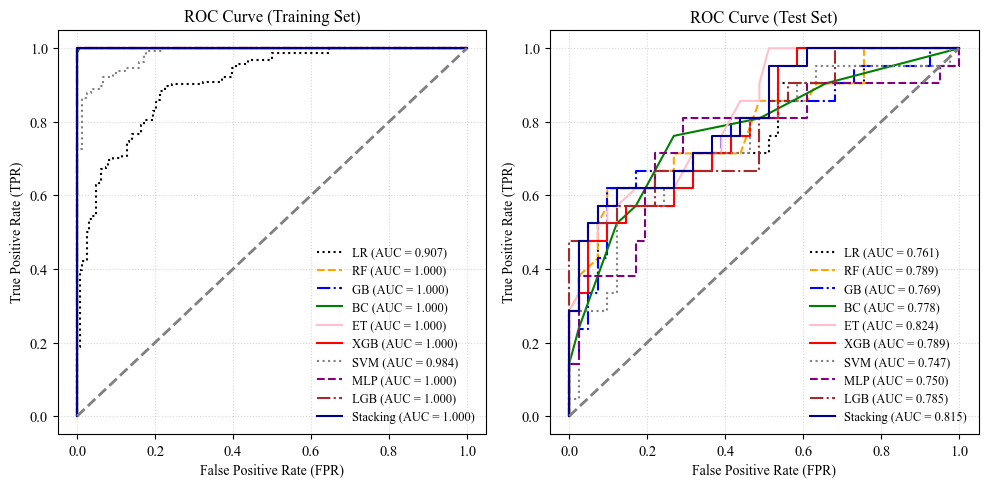

Font name: Songti SC
Font file: /System/Library/Fonts/Supplemental/Songti.ttc
Weight: normal


In [102]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, BaggingClassifier,
                              ExtraTreesClassifier, StackingClassifier)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 设置英文新罗马字体（Times New Roman）
mpl.rcParams['font.sans-serif'] = 'Times New Roman'  # 新罗马 
mpl.rcParams['font.family'] = 'serif'  # 指定为衬线字体
# 解决负号显示问题
mpl.rcParams['axes.unicode_minus'] = False

# 缺失值填充+标准化流水线（直接返回单层Pipeline，避免嵌套）
def create_preprocessing(need_scaling=True):
    steps = [('imputer', SimpleImputer(strategy='mean'))]  # 均值填充缺失值
    if need_scaling:
        steps.append(('scaler', StandardScaler()))
    return Pipeline(steps=steps)

# 定义所有分类器（集成预处理流水线）
mlp = Pipeline([
    ('preprocess', create_preprocessing(need_scaling=True)),
    ('model', MLPClassifier(hidden_layer_sizes=(200,), random_state=SEED, max_iter=10000))
])
lr = Pipeline([
    ('preprocess', create_preprocessing(need_scaling=True)),
    ('model', LogisticRegression(random_state=SEED))
])
rf = Pipeline([
    ('preprocess', create_preprocessing(need_scaling=False)),  # 树模型无需标准化
    ('model', RandomForestClassifier(random_state=SEED))
])
gb = Pipeline([
    ('preprocess', create_preprocessing(need_scaling=False)),
    ('model', GradientBoostingClassifier(random_state=SEED))
])
bc = Pipeline([
    ('preprocess', create_preprocessing(need_scaling=False)),
    ('model', BaggingClassifier(random_state=SEED))
])
et = Pipeline([
    ('preprocess', create_preprocessing(need_scaling=False)),
    ('model', ExtraTreesClassifier(random_state=SEED))
])
xgb = Pipeline([
    ('preprocess', create_preprocessing(need_scaling=False)),
    ('model', XGBClassifier(random_state=SEED, missing=np.nan))
])
svm = Pipeline([
    ('preprocess', create_preprocessing(need_scaling=True)),
    ('model', SVC(random_state=SEED, probability=True))
])
lgb = Pipeline([
    ('preprocess', create_preprocessing(need_scaling=False)),
    ('model', LGBMClassifier(verbose=-1, random_state=SEED, missing=np.nan))
])

# 新增Stacking集成模型
base_estimators = [('rf', rf), ('xgb', xgb), ('lgb', lgb), ('et', et)]
meta_classifier = Pipeline([
    ('preprocess', create_preprocessing(need_scaling=True)),
    ('model', LogisticRegression(random_state=SEED))
])
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_classifier,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# 模型列表、标签、颜色、线型
all_clf = [lr, rf, gb, bc, et, xgb, svm, mlp, lgb, stacking_clf]
clf_labels = ["LR", "RF", "GB", "BC", "ET", "XGB", "SVM", "MLP", "LGB", "Stacking"]
colors = ["black", "orange", "blue", "green", "pink", "red", "gray", "purple", "brown", "darkblue"]
linestyles = [":", "--", "-.", "-", "-", "-", ":", "--", "-.", "-"]

# 转换数据为数值型（非数值列转为NaN后填充）
x_train = x_train.apply(pd.to_numeric, errors='coerce')
x_test = x_test.apply(pd.to_numeric, errors='coerce')

# 绘制1张图（2个子图：训练集+测试集）
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# 绘制ROC曲线函数
def plot_roc(ax, data_type, x_data, y_data):
    ax.set_title(f'ROC Curve ({data_type})', fontsize=12)
    for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
        clf.fit(x_train, y_train)  # 训练集训练
        y_pred_prob = clf.predict_proba(x_data)[:, 1]  # 预测概率
        fpr, tpr, _ = roc_curve(y_data, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, color=clr, linestyle=ls, linewidth=1.5,
                label=f'%s (AUC = %0.3f)' % (label, roc_auc))
    
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)  # 基准线
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate (FPR)', fontsize=10)
    ax.set_ylabel('True Positive Rate (TPR)', fontsize=10)
    ax.grid(alpha=0.5, linestyle=':')
    ax.legend(loc='lower right', fontsize=9,frameon=False)

# 绘制两个子图
plot_roc(ax1, 'Training Set', x_train, y_train)
plot_roc(ax2, 'Test Set', x_test, y_test)

plt.tight_layout()  # 调整间距
plt.savefig('Train_Test_ROC_Curves.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()
import matplotlib.font_manager as fm

leg = ax.get_legend()  # 如果你是 plt.legend()，那就 leg = plt.gca().get_legend()
t = leg.get_texts()[0]  # 取图例第一条文字
fp = t.get_fontproperties()

print("Font name:", fp.get_name())
print("Font file:", fm.findfont(fp, fallback_to_default=True))
print("Weight:", fp.get_weight())

# 5折交叉验证+贝叶斯优化超参数

In [103]:
# ====================== 1. 导入库与基础设置 ======================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              BaggingClassifier, ExtraTreesClassifier, StackingClassifier)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

# 基础配置
os.environ["LOKY_MAX_CPU_COUNT"] = "4"
SEED = 42
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False

# ====================== 3. 预处理流水线 ======================
def create_preprocessing(need_scaling=True):
    steps = [('imputer', SimpleImputer(strategy='mean'))]
    if need_scaling:
        steps.append(('scaler', StandardScaler()))
    return Pipeline(steps=steps)

# ====================== 4. 贝叶斯优化（Optuna）配置 ======================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
sampler = TPESampler(seed=SEED)
pruner = MedianPruner(n_warmup_steps=5)

def optimize_model(trial, model_name):
    need_scaling = model_name in ["LR", "SVM", "MLP"]
    preprocess = create_preprocessing(need_scaling=need_scaling)
    
    if model_name == "LR":
        # LR：penalty与solver严格匹配
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
        if penalty == 'elasticnet':
            solver = 'saga'
        elif penalty == 'l1':
            solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
        else:  # l2
            solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
        
        params = {
            'C': trial.suggest_float('C', 1e-4, 1e4, log=True),
            'penalty': penalty,
            'solver': solver,
            'l1_ratio': trial.suggest_float('l1_ratio', 0.0, 1.0) if penalty == 'elasticnet' else 0.5,
            'max_iter': trial.suggest_int('max_iter', 200, 2000, step=200),
            'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
        }
        model = LogisticRegression(random_state=SEED, **params)
    
    elif model_name == "RF":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=50),
            'max_depth': trial.suggest_categorical('max_depth', [None, 5, 10, 20, 30]),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample'])
        }
        model = RandomForestClassifier(random_state=SEED, **params)
    
    elif model_name == "GB":
        # GB：兼容sklearn新版本，仅保留有效loss选项
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=50),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 15, step=2),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'loss': trial.suggest_categorical('loss', ['log_loss', 'exponential'])
        }
        model = GradientBoostingClassifier(random_state=SEED, **params)
    
    elif model_name == "BC":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
            'max_samples': trial.suggest_float('max_samples', 0.5, 1.0),
            'max_features': trial.suggest_float('max_features', 0.5, 1.0),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'bootstrap_features': trial.suggest_categorical('bootstrap_features', [True, False])
        }
        model = BaggingClassifier(random_state=SEED, **params)
    
    elif model_name == "ET":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=50),
            'max_depth': trial.suggest_categorical('max_depth', [None, 5, 10, 20, 30]),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample'])
        }
        model = ExtraTreesClassifier(random_state=SEED, **params)
    
    elif model_name == "XGB":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=50),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 15, step=2),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0.0, 10.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 1e2, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 1e2, log=True),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 5.0)
        }
        model = XGBClassifier(random_state=SEED, missing=np.nan, verbosity=0, **params)
    
    elif model_name == "SVM":
        # 为不同核函数的gamma分配不同参数名，避免分布冲突
        kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
        
        if kernel == 'rbf':
            # rbf核：gamma用categorical分布（scale/auto）
            gamma = trial.suggest_categorical('gamma_categorical', ['scale', 'auto'])
        else:
            # 其他核：gamma用float分布，参数名改为gamma_float
            gamma = trial.suggest_float('gamma_float', 1e-4, 1e2, log=True)
        
        params = {
            'C': trial.suggest_float('C', 1e-3, 1e3, log=True),
            'kernel': kernel,
            'gamma': gamma,
            'degree': trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3,
            'coef0': trial.suggest_float('coef0', 0.0, 5.0),
            'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
            'max_iter': trial.suggest_int('max_iter', -1, 2000, step=500)
        }
        model = SVC(random_state=SEED, probability=True, **params)
    
    elif model_name == "MLP":
        params = {
            'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(100,), (200,), (100, 50), (200, 100)]),
            'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic']),
            'solver': trial.suggest_categorical('solver', ['adam', 'lbfgs']),
            'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
            'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True),
            'alpha': trial.suggest_float('alpha', 1e-4, 1e2, log=True),
            'max_iter': trial.suggest_int('max_iter', 5000, 20000, step=5000),
            'batch_size': trial.suggest_categorical('batch_size', ['auto', 32, 64, 128])
        }
        model = MLPClassifier(random_state=SEED, **params)
    
    elif model_name == "LGB":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=50),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 15, step=2),
            'num_leaves': trial.suggest_int('num_leaves', 10, 100, step=10),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 1e2, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 1e2, log=True),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 5.0)
        }
        model = LGBMClassifier(random_state=SEED, verbose=-1, **params)
    
    # 构建流水线并交叉验证
    pipeline = Pipeline([('preprocess', preprocess), ('model', model)])
    cv_aucs = []
    for train_idx, val_idx in cv.split(x_train, y_train):
        x_cv_train, x_cv_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
        y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        pipeline.fit(x_cv_train, y_cv_train)
        y_pred_prob = pipeline.predict_proba(x_cv_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_cv_val, y_pred_prob)
        cv_aucs.append(auc(fpr, tpr))
    
    return np.mean(cv_aucs)

# 执行贝叶斯优化（单线程稳定运行）
model_names = ["LR", "RF", "GB", "BC", "ET", "XGB", "SVM", "MLP", "LGB"]
best_models = {}

print("=== 贝叶斯优化（Optuna）搜索最优参数 ===")
for name in model_names:
    study = optuna.create_study(
        direction='maximize',
        sampler=sampler,
        pruner=pruner,
        study_name=f"{name}_Optimization",
        load_if_exists=False
    )
    # 单线程运行，避免参数传递异常
    study.optimize(
        lambda trial: optimize_model(trial, name),
        n_trials=30,  # 平衡速度和效果
        show_progress_bar=True,
        n_jobs=1
    )
    
    # 重建最优模型（处理SVM的gamma参数名映射）
    need_scaling = name in ["LR", "SVM", "MLP"]
    preprocess = create_preprocessing(need_scaling=need_scaling)
    best_trial = study.best_trial
    best_params = best_trial.params
    
    # 按模型类型重建
    if name == "LR":
        penalty = best_params['penalty']
        if penalty == 'elasticnet':
            best_params['solver'] = 'saga'
        best_model = LogisticRegression(random_state=SEED, **best_params)
    elif name == "RF":
        best_model = RandomForestClassifier(random_state=SEED, **best_params)
    elif name == "GB":
        best_model = GradientBoostingClassifier(random_state=SEED, **best_params)
    elif name == "BC":
        best_model = BaggingClassifier(random_state=SEED, **best_params)
    elif name == "ET":
        best_model = ExtraTreesClassifier(random_state=SEED, **best_params)
    elif name == "XGB":
        best_model = XGBClassifier(random_state=SEED, missing=np.nan, verbosity=0, **best_params)
    elif name == "SVM":
        # 处理SVM的gamma参数名映射
        kernel = best_params['kernel']
        if kernel == 'rbf':
            # 从gamma_categorical提取值，赋值给gamma
            best_params['gamma'] = best_params.pop('gamma_categorical', 'scale')
        else:
            # 从gamma_float提取值，赋值给gamma
            best_params['gamma'] = best_params.pop('gamma_float', 1e-3)
        # 删除可能残留的无效参数名
        for key in ['gamma_categorical', 'gamma_float']:
            best_params.pop(key, None)
        best_model = SVC(random_state=SEED, probability=True, **best_params)
    elif name == "MLP":
        best_model = MLPClassifier(random_state=SEED, **best_params)
    elif name == "LGB":
        best_model = LGBMClassifier(random_state=SEED, verbose=-1, **best_params)
    
    # 训练并保存最优模型
    best_pipeline = Pipeline([('preprocess', preprocess), ('model', best_model)])
    best_pipeline.fit(x_train, y_train)
    best_models[name] = best_pipeline
    
    print(f"\n{name} 最优参数：{best_params}")
    print(f"{name} 交叉验证最优AUC：{best_trial.value:.3f}")

# ====================== 5. Stacking集成模型 ======================
base_estimators = [(name, best_models[name]) for name in ["RF", "XGB", "LGB", "ET"]]
meta_classifier = Pipeline([
    ('preprocess', create_preprocessing(need_scaling=True)),
    ('model', LogisticRegression(random_state=SEED))
])

stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_classifier,
    cv=cv,
    n_jobs=-1,
    passthrough=False
)
stacking_clf.fit(x_train, y_train)
best_models["Stacking"] = stacking_clf
print("\nStacking模型训练完成")

[I 2025-12-30 07:32:11,589] A new study created in memory with name: LR_Optimization


=== 贝叶斯优化（Optuna）搜索最优参数 ===


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-30 07:32:11,609] Trial 0 finished with value: 0.8305383379247016 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.0017699302940633358, 'max_iter': 200, 'class_weight': None}. Best is trial 0 with value: 0.8305383379247016.
[I 2025-12-30 07:32:11,727] Trial 1 finished with value: 0.8328914141414142 and parameters: {'penalty': 'elasticnet', 'C': 456.6054873446131, 'l1_ratio': 0.21233911067827616, 'max_iter': 400, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8328914141414142.
[I 2025-12-30 07:32:11,742] Trial 2 finished with value: 0.7407799586776859 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.02173487707341741, 'max_iter': 800, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8328914141414142.
[I 2025-12-30 07:32:11,756] Trial 3 finished with value: 0.5 and parameters: {'penalty': 'elasticnet', 'C': 0.00023528990899815348, 'l1_ratio': 0.6075448519014384, 'max_iter': 400, 'class_weight': 'balanced'}. Best is trial 1 wit

[I 2025-12-30 07:32:14,603] A new study created in memory with name: RF_Optimization


[I 2025-12-30 07:32:14,582] Trial 29 finished with value: 0.8373393021120293 and parameters: {'penalty': 'elasticnet', 'C': 0.6549052659003445, 'l1_ratio': 0.9813130867582934, 'max_iter': 200, 'class_weight': None}. Best is trial 14 with value: 0.8387281910009182.

LR 最优参数：{'penalty': 'l1', 'solver': 'saga', 'C': 0.3874000196309621, 'max_iter': 600, 'class_weight': None}
LR 交叉验证最优AUC：0.839


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-30 07:32:15,786] Trial 0 finished with value: 0.9149850780532599 and parameters: {'n_estimators': 450, 'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': None}. Best is trial 0 with value: 0.9149850780532599.
[I 2025-12-30 07:32:17,195] Trial 1 finished with value: 0.9320994031221306 and parameters: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9320994031221306.
[I 2025-12-30 07:32:18,257] Trial 2 finished with value: 0.902548209366391 and parameters: {'n_estimators': 450, 'max_depth': None, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9320994031221306.
[I 2025-12-30 07:32:20,193] Trial 3 finished with value: 0.9151802112029385 and parameters: {'n_estimators': 

[I 2025-12-30 07:32:50,706] A new study created in memory with name: GB_Optimization



RF 最优参数：{'n_estimators': 400, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced_subsample'}
RF 交叉验证最优AUC：0.939


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-30 07:32:53,309] Trial 0 finished with value: 0.9379648760330579 and parameters: {'n_estimators': 500, 'learning_rate': 0.1297202725902156, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 9, 'subsample': 0.6584610025781388, 'max_features': None, 'loss': 'log_loss'}. Best is trial 0 with value: 0.9379648760330579.
[I 2025-12-30 07:32:53,532] Trial 1 finished with value: 0.9367940771349863 and parameters: {'n_estimators': 50, 'learning_rate': 0.033377013398032084, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.9386865359639778, 'max_features': 'sqrt', 'loss': 'log_loss'}. Best is trial 0 with value: 0.9379648760330579.
[I 2025-12-30 07:32:54,853] Trial 2 finished with value: 0.9387454086317722 and parameters: {'n_estimators': 450, 'learning_rate': 0.10156617769867014, 'max_depth': 15, 'min_samples_split': 19, 'min_samples_leaf': 6, 'subsample': 0.7507581473435998, 'max_features': 'sqrt', 'loss': 'exponential'}. Best is trial 2 with v

[I 2025-12-30 07:33:23,178] A new study created in memory with name: BC_Optimization



GB 最优参数：{'n_estimators': 300, 'learning_rate': 0.09138334502914983, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 2, 'subsample': 0.6408372580289353, 'max_features': 'log2', 'loss': 'log_loss'}
GB 交叉验证最优AUC：0.946


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-30 07:33:24,967] Trial 0 finished with value: 0.9339560376492196 and parameters: {'n_estimators': 300, 'max_samples': 0.7877370889379395, 'max_features': 0.694084963103261, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 0 with value: 0.9339560376492196.
[I 2025-12-30 07:33:26,205] Trial 1 finished with value: 0.9390725436179981 and parameters: {'n_estimators': 150, 'max_samples': 0.9805952819119571, 'max_features': 0.9526753209780319, 'bootstrap': True, 'bootstrap_features': True}. Best is trial 1 with value: 0.9390725436179981.
[I 2025-12-30 07:33:26,578] Trial 2 finished with value: 0.9307392102846649 and parameters: {'n_estimators': 50, 'max_samples': 0.8415033867081785, 'max_features': 0.5355943242301144, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 1 with value: 0.9390725436179981.
[I 2025-12-30 07:33:27,256] Trial 3 finished with value: 0.9291322314049587 and parameters: {'n_estimators': 100, 'max_samples': 0.5590824138108281, 'max_fe

[I 2025-12-30 07:34:01,507] A new study created in memory with name: ET_Optimization



BC 最优参数：{'n_estimators': 200, 'max_samples': 0.8052411941426503, 'max_features': 0.9243654148098501, 'bootstrap': True, 'bootstrap_features': True}
BC 交叉验证最优AUC：0.941


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-30 07:34:01,806] Trial 0 finished with value: 0.8957702020202021 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': False, 'class_weight': None}. Best is trial 0 with value: 0.8957702020202021.
[I 2025-12-30 07:34:02,626] Trial 1 finished with value: 0.8762396694214875 and parameters: {'n_estimators': 450, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True, 'class_weight': None}. Best is trial 0 with value: 0.8957702020202021.
[I 2025-12-30 07:34:02,869] Trial 2 finished with value: 0.8678719008264462 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.8957702020202021.
[I 2025-12-30 07:34:02,948] Trial 3 finished with value: 0.8838211662075299 and parameters: {'n_estimators'

[I 2025-12-30 07:34:28,207] A new study created in memory with name: XGB_Optimization



ET 最优参数：{'n_estimators': 350, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced_subsample'}
ET 交叉验证最优AUC：0.948


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-30 07:34:28,501] Trial 0 finished with value: 0.8414600550964189 and parameters: {'n_estimators': 100, 'learning_rate': 0.0023783808026000817, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.5909400421995724, 'colsample_bytree': 0.6728336416619316, 'gamma': 8.967884099060118, 'reg_alpha': 0.06978624673182436, 'reg_lambda': 1.012386700110598, 'scale_pos_weight': 1.2754394204073343}. Best is trial 0 with value: 0.8414600550964189.
[I 2025-12-30 07:34:28,924] Trial 1 finished with value: 0.8964244719926538 and parameters: {'n_estimators': 100, 'learning_rate': 0.0012625149165973475, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.5885052421383734, 'colsample_bytree': 0.5443512668785278, 'gamma': 1.206358711006008, 'reg_alpha': 0.05816645660821985, 'reg_lambda': 0.0017298255618152594, 'scale_pos_weight': 2.1392143747163397}. Best is trial 1 with value: 0.8964244719926538.
[I 2025-12-30 07:34:29,237] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 30

[I 2025-12-30 07:34:48,825] A new study created in memory with name: SVM_Optimization



XGB 最优参数：{'n_estimators': 200, 'learning_rate': 0.004469955258566802, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.8600493003694574, 'colsample_bytree': 0.8750487070228609, 'gamma': 7.7026968222405605, 'reg_alpha': 0.002420513279348986, 'reg_lambda': 0.004456571987328276, 'scale_pos_weight': 2.9460779884283115}
XGB 交叉验证最优AUC：0.927


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-30 07:34:48,898] Trial 0 finished with value: 0.4619375573921028 and parameters: {'kernel': 'rbf', 'gamma_categorical': 'auto', 'C': 0.028474649993162904, 'coef0': 0.5741841236960177, 'class_weight': None, 'max_iter': 999}. Best is trial 0 with value: 0.4619375573921028.
[I 2025-12-30 07:34:48,939] Trial 1 finished with value: 0.1707242883379247 and parameters: {'kernel': 'sigmoid', 'gamma_float': 0.00020461676818738251, 'C': 0.10462263868584756, 'coef0': 0.6720733846948712, 'class_weight': 'balanced', 'max_iter': 499}. Best is trial 0 with value: 0.4619375573921028.
[I 2025-12-30 07:34:48,989] Trial 2 finished with value: 0.8761019283746556 and parameters: {'kernel': 'rbf', 'gamma_categorical': 'scale', 'C': 0.6752383987148561, 'coef0': 2.059204570736343, 'class_weight': 'balanced', 'max_iter': 1999}. Best is trial 2 with value: 0.8761019283746556.
[I 2025-12-30 07:34:49,046] Trial 3 finished with value: 0.17278466483011937 and parameters: {'kernel': 'rbf', 'gamma_categoric

[I 2025-12-30 07:34:50,229] A new study created in memory with name: MLP_Optimization


[I 2025-12-30 07:34:50,178] Trial 28 finished with value: 0.9314393939393939 and parameters: {'kernel': 'poly', 'gamma_float': 77.77751413142836, 'C': 0.0011690178201091285, 'degree': 3, 'coef0': 1.4469238385330079, 'class_weight': None, 'max_iter': 1999}. Best is trial 25 with value: 0.9314393939393939.
[I 2025-12-30 07:34:50,219] Trial 29 finished with value: 0.5982265840220385 and parameters: {'kernel': 'sigmoid', 'gamma_float': 73.51458902420978, 'C': 0.003925090753610576, 'coef0': 1.4676302519723754, 'class_weight': None, 'max_iter': 1999}. Best is trial 25 with value: 0.9314393939393939.

SVM 最优参数：{'kernel': 'poly', 'C': 0.14376129867596016, 'degree': 3, 'coef0': 0.03432286127878528, 'class_weight': None, 'max_iter': 1999, 'gamma': 11.811256451856936}
SVM 交叉验证最优AUC：0.931


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-30 07:34:53,827] Trial 0 finished with value: 0.8490013774104683 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'logistic', 'solver': 'lbfgs', 'learning_rate': 'constant', 'learning_rate_init': 0.006998400016066854, 'alpha': 1.7515873735242888, 'max_iter': 5000, 'batch_size': 128}. Best is trial 0 with value: 0.8490013774104683.
[I 2025-12-30 07:35:11,359] Trial 1 finished with value: 0.914175849403122 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'learning_rate': 'invscaling', 'learning_rate_init': 0.00012868362240023423, 'alpha': 0.01026085262319095, 'max_iter': 20000, 'batch_size': 128}. Best is trial 1 with value: 0.914175849403122.
[I 2025-12-30 07:35:13,756] Trial 2 finished with value: 0.9150539485766759 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'lbfgs', 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005306251107511992, 'alpha': 0.304459900889827, 'max_iter': 1500

[I 2025-12-30 07:44:03,838] A new study created in memory with name: LGB_Optimization



MLP 最优参数：{'hidden_layer_sizes': (200,), 'activation': 'relu', 'solver': 'adam', 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005217854149110251, 'alpha': 0.00013339707114794677, 'max_iter': 20000, 'batch_size': 32}
MLP 交叉验证最优AUC：0.926


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-30 07:44:03,905] Trial 0 finished with value: 0.8576503673094582 and parameters: {'n_estimators': 50, 'learning_rate': 0.016965215517282743, 'max_depth': 11, 'num_leaves': 40, 'min_child_samples': 25, 'subsample': 0.5532991265668858, 'colsample_bytree': 0.5375688908679044, 'reg_alpha': 2.33955110979333, 'reg_lambda': 0.09396105777395802, 'scale_pos_weight': 3.597810783924812}. Best is trial 0 with value: 0.8576503673094582.
[I 2025-12-30 07:44:04,029] Trial 1 finished with value: 0.8726354453627181 and parameters: {'n_estimators': 250, 'learning_rate': 0.004077253495648021, 'max_depth': 13, 'num_leaves': 80, 'min_child_samples': 23, 'subsample': 0.6360725686149813, 'colsample_bytree': 0.7951153334345435, 'reg_alpha': 0.014650194199743477, 'reg_lambda': 0.0003543989609792364, 'scale_pos_weight': 4.627911089580093}. Best is trial 1 with value: 0.8726354453627181.
[I 2025-12-30 07:44:04,073] Trial 2 finished with value: 0.9027777777777779 and parameters: {'n_estimators': 100, '

# 模型性能评估指标计算

In [104]:
# ====================== 1. 导入库与基础设置 ======================
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (roc_curve, auc, accuracy_score, 
                             precision_score, recall_score, confusion_matrix)


# ====================== 计算所有模型的训练集+测试集多指标 ======================
def calculate_metrics(y_true, y_pred, y_pred_prob):
    """计算单个数据集的所有指标"""
    # 混淆矩阵（TN, FP, FN, TP）
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # 各指标计算
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)  # 避免除以0
    recall = recall_score(y_true, y_pred, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0.0  # 特异性（真阴性率）
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    return {
        "Accuracy": round(accuracy, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "Specificity": round(specificity, 3),
        "ROC-AUC": round(roc_auc, 3)
    }

# 存储所有模型的指标
all_metrics = []

# 遍历所有模型（包括Stacking）
for model_name, model in best_models.items():
    # 训练集预测
    y_train_pred = model.predict(x_train)
    y_train_pred_prob = model.predict_proba(x_train)
    
    # 测试集预测
    y_test_pred = model.predict(x_test)
    y_test_pred_prob = model.predict_proba(x_test)
    
    # 计算训练集指标
    train_metrics = calculate_metrics(y_train, y_train_pred, y_train_pred_prob)
    # 计算测试集指标
    test_metrics = calculate_metrics(y_test, y_test_pred, y_test_pred_prob)
    
    # 合并指标（区分训练集/测试集）
    metrics_row = {
        "Model": model_name,
        "Train_Accuracy": train_metrics["Accuracy"],
        "Train_Precision": train_metrics["Precision"],
        "Train_Recall": train_metrics["Recall"],
        "Train_Specificity": train_metrics["Specificity"],
        "Train_ROC-AUC": train_metrics["ROC-AUC"],
        "Test_Accuracy": test_metrics["Accuracy"],
        "Test_Precision": test_metrics["Precision"],
        "Test_Recall": test_metrics["Recall"],
        "Test_Specificity": test_metrics["Specificity"],
        "Test_ROC-AUC": test_metrics["ROC-AUC"]
    }
    all_metrics.append(metrics_row)

# 转为DataFrame
metrics_df = pd.DataFrame(all_metrics)

# 打印结果（按测试集ROC-AUC降序排序）
print("\n=== 所有模型训练集+测试集指标汇总 ===")
metrics_df_sorted = metrics_df.sort_values("Test_ROC-AUC", ascending=False)
# 保存为CSV文件
metrics_df_sorted.to_csv("model_performance_metrics.csv", index=False)
print("\n指标表格已保存为 model_performance_metrics.csv")

metrics_df_sorted


=== 所有模型训练集+测试集指标汇总 ===

指标表格已保存为 model_performance_metrics.csv


,Model,Train_Accuracy,Train_Precision,Train_Recall,Train_Specificity,Train_ROC-AUC,Test_Accuracy,Test_Precision,Test_Recall,Test_Specificity,Test_ROC-AUC
1,RF,1.000,1.000,1.000,1.000,1.000,0.790,0.833,0.476,0.951,0.812
9,Stacking,1.000,1.000,1.000,1.000,1.000,0.758,0.750,0.429,0.927,0.807
4,ET,1.000,1.000,1.000,1.000,1.000,0.774,0.769,0.476,0.927,0.805
3,BC,1.000,1.000,1.000,1.000,1.000,0.806,0.846,0.524,0.951,0.780
5,XGB,0.863,0.785,1.000,0.726,0.997,0.677,0.516,0.762,0.634,0.780
6,SVM,1.000,1.000,1.000,1.000,1.000,0.742,0.692,0.429,0.902,0.777
8,LGB,1.000,1.000,1.000,1.000,1.000,0.790,0.833,0.476,0.951,0.776
2,GB,1.000,1.000,1.000,1.000,1.000,0.774,0.769,0.476,0.927,0.768
0,LR,0.790,0.828,0.732,0.848,0.900,0.790,0.750,0.571,0.902,0.758
7,MLP,1.000,1.000,1.000,1.000,1.000,0.694,0.571,0.381,0.854,0.750


# 测试集性能指标对比玫瑰图

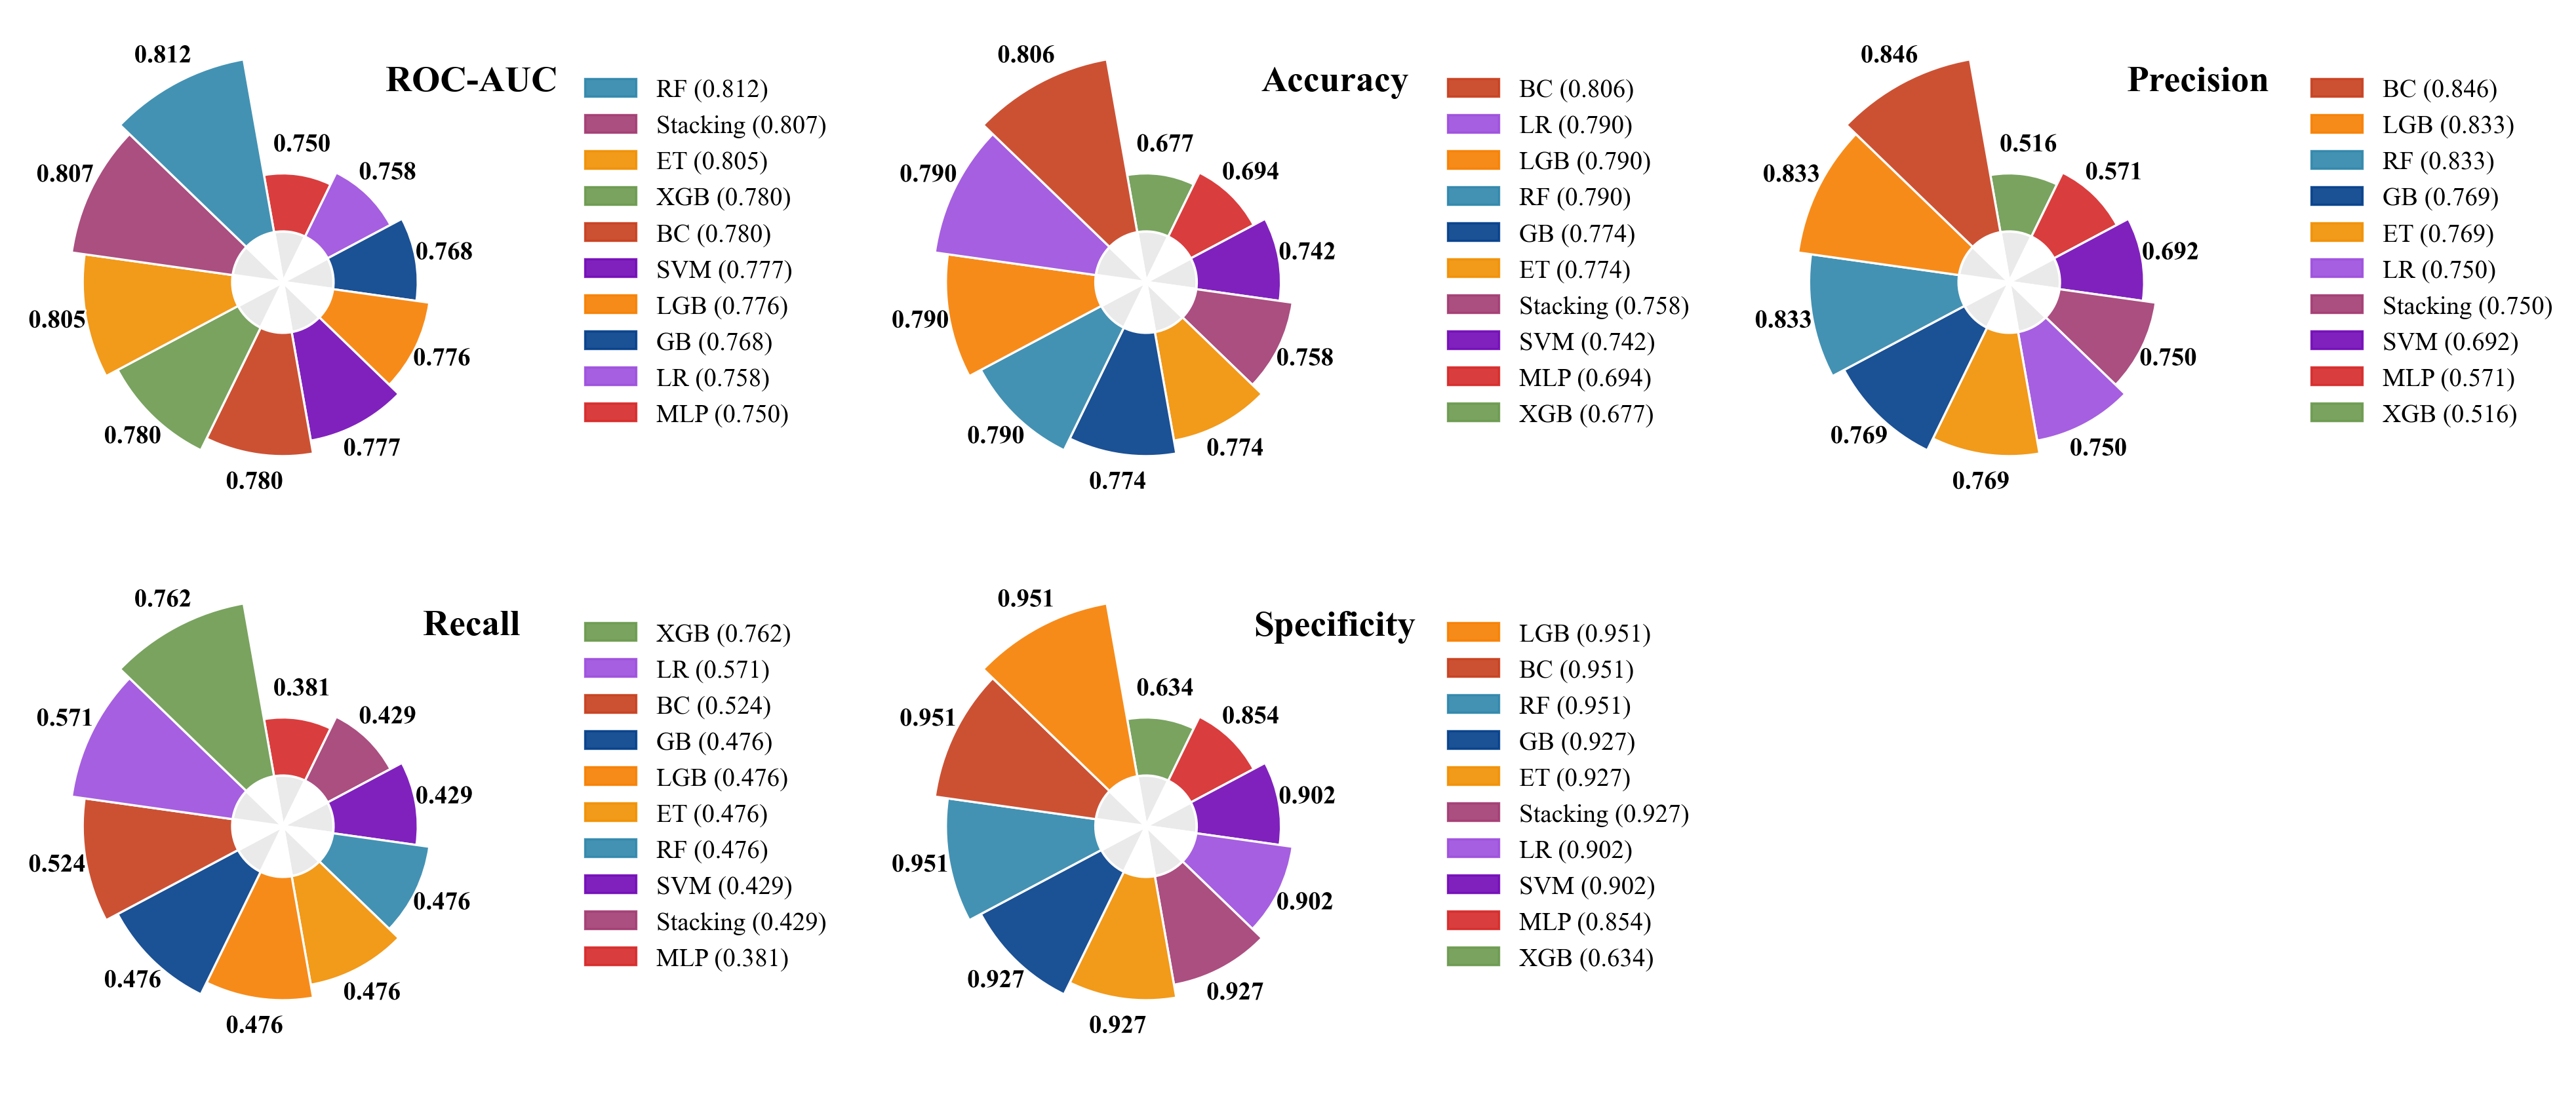

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as patheffects

# ---------------------- 绘制单个玫瑰图（图例1列，子图2×3布局） ----------------------
def draw_rose_chart(ax, metric_name, model_names, metric_values, colors):
    # 按指标值升序排序（扇形半径递增）
    sorted_idx = np.argsort(metric_values)
    sorted_vals = [metric_values[i] for i in sorted_idx]
    sorted_names = [model_names[i] for i in sorted_idx]
    sorted_colors = [colors[i] for i in sorted_idx]
    
    num_models = len(sorted_names)
    if sum(sorted_vals) == 0:
        ax.text(0.5, 0.5, f'{metric_name}\n(无有效数据)', 
                fontsize=24, fontweight='bold', ha='center', va='center', transform=ax.transAxes)
        return

    # 基础配置（10个模型平均分配角度）
    widths = [2 * np.pi / num_models for _ in range(num_models)]
    base_radius = 0.35
    radius_inc = 0.09
    outer_radii = [base_radius + i * radius_inc for i in range(num_models)]
    thetas = np.cumsum([0] + widths[:-1]) - np.pi/18  # 12点钟方向开始

    # 绘制内部灰白交替扇形
    inner_colors = ['#EAEAEA' if i%2==0 else '#FFFFFF' for i in range(num_models)]
    for i in range(num_models):
        ax.bar(thetas[i], base_radius, widths[i], bottom=0.0, color=inner_colors[i],
               align='edge', edgecolor='white', linewidth=1.5, zorder=1)

    # 绘制外部彩色扇形
    for i in range(num_models):
        ring_h = outer_radii[i] - base_radius
        ax.bar(thetas[i], ring_h + 0.4, widths[i], bottom=base_radius, color=sorted_colors[i],
               align='edge', edgecolor='white', linewidth=1.2, zorder=2)

    # 中心小圆
    ax.bar([0], 0.02, [2*np.pi], color='white', align='edge', zorder=3)

    # 数值标签（外侧）
    for i in range(num_models):
        label_angle = thetas[i] + widths[i]/2
        ax.text(label_angle, outer_radii[i]+0.6, f'{sorted_vals[i]:.3f}',
                fontsize=14, fontweight='bold', ha='center', va='center',
                color='black', path_effects=[patheffects.withStroke(linewidth=2.0, foreground='white')], zorder=4)

    # 子图标题
    ax.text(0.85, 0.90, metric_name, fontsize=20, fontweight='bold',
            fontfamily='Times New Roman', ha='center', va='top', transform=ax.transAxes)

    # 图例（1列排列）
    legend_handles = [mpatches.Patch(color=sorted_colors[i], label=f"{sorted_names[i]} ({sorted_vals[i]:.3f})",
                                    edgecolor='white', linewidth=1.2) for i in range(num_models)][::-1]
    ax.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1.55, 0.92),
              frameon=False, shadow=True, fontsize=14, title_fontsize=16, ncol=1)

    # 子图格式优化
    ax.set_yticklabels([]), ax.set_xticklabels([])
    ax.spines['polar'].set_visible(False), ax.grid(False)
    ax.set_theta_zero_location('N'), ax.set_theta_direction(-1)
    ax.set_ylim(0, max(outer_radii) + 0.7)

# ---------------------- 数据预处理 ----------------------
def preprocess_data(metrics_df):
    model_names = metrics_df['Model'].tolist()
    # ROC-AUC 放在第一个位置
    metrics = ['Test_ROC-AUC', 'Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_Specificity']
    metric_data = {}
    for m in metrics:
        metric_data[m] = pd.to_numeric(metrics_df[m], errors='coerce').fillna(0.0).tolist()
    return model_names, metrics, metric_data

# ---------------------- 主程序 ----------------------
if __name__ == "__main__":
    # 全局字体设置
    plt.rcParams.update({
        'font.family': 'Times New Roman', 'font.size': 16, 'axes.unicode_minus': False,
        'figure.dpi': 200, 'savefig.dpi': 300
    })

    # 检查指标数据
    if 'metrics_df_sorted' not in locals():
        raise ValueError("请先运行模型训练和指标计算代码，确保 metrics_df_sorted 变量存在！")

    # 数据预处理
    model_names, metrics, metric_data = preprocess_data(metrics_df_sorted)

    # ---------------------- 学术风配色（10种低饱和、高区分度颜色） ----------------------
    # 配色逻辑：冷色+暖色搭配，避免相近色
    academic_colors = [
        '#2E86AB',  # 深蓝（冷色）
        '#A23B72',  # 深紫（暖色）
        '#F18F01',  # 暖黄（低饱和）
        '#C73E1D',  # 深红（低饱和）
        '#6A994E',  # 深绿（冷色）
        '#7209B7',  # 深紫蓝（冷色）
        '#F77F00',  # 橙黄（暖色）
        '#023E8A',  # 藏青（冷色）
        '#9D4EDD',  # 浅紫（冷色）
        '#D62828'   # 大红（暖色）
    ]
    # 转换为RGBA（透明度0.9，保持层次感）
    colors = [(np.array([int(c[1:3],16), int(c[3:5],16), int(c[5:7],16)])/255).tolist() + [0.9] for c in academic_colors]

    # 2×3子图布局（5个指标+1个隐藏空图）
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), subplot_kw={'projection': 'polar'},
                             gridspec_kw={'hspace':-0.3, 'wspace':0.6, 'left':0.02, 'right':0.98, 'top':0.92, 'bottom':0.08})
    axes = axes.flatten()

    # 绘制5个指标的玫瑰图
    for idx, m in enumerate(metrics):
        draw_rose_chart(axes[idx], m.replace('Test_', ''), model_names, metric_data[m], colors)

    # 隐藏第6个空子图
    axes[5].set_visible(False)

    # 保存
    plt.savefig('10models_5metrics_rose_chart.pdf', bbox_inches='tight', dpi=600, pad_inches=0.8)
    plt.show()

# 各模型五折交叉验证过程每一折ROC曲线

In [106]:
# # ====================== 6. 绘制10个模型的5折ROC曲线 ======================
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.patches import Rectangle
# from matplotlib.colors import LinearSegmentedColormap
# import string
# from sklearn.metrics import roc_curve, auc

# # ---------------------- 配置参数 ----------------------
# model_names = ["LR", "RF", "GB", "BC", "ET", "XGB", "SVM", "MLP", "LGB", "Stacking"]
# fold_labels = [f'Fold {i+1}' for i in range(5)]

# # ---------------------- 第一步：计算5折交叉验证的FPR、TPR、AUC ----------------------
# model_cv_roc_data = {}

# for model_name in model_names:
#     model = best_models[model_name]
#     fold_roc_data = []
    
#     for fold_idx, (train_idx, val_idx) in enumerate(cv.split(x_train, y_train)):
#         x_cv_train, x_cv_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
#         y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
#         model.fit(x_cv_train, y_cv_train)
#         y_pred_prob = model.predict_proba(x_cv_val)[:, 1]
        
#         fpr, tpr, _ = roc_curve(y_cv_val, y_pred_prob)
#         roc_auc = auc(fpr, tpr)
#         fold_roc_data.append((fpr, tpr, roc_auc))
    
#     model_cv_roc_data[model_name] = fold_roc_data
#     print(f"{model_name} 5折AUC：{[round(data[2], 3) for data in fold_roc_data]}，平均：{np.mean([data[2] for data in fold_roc_data]):.3f}")

In [107]:
# ====================== 6. 绘制10个模型的5折ROC曲线 ======================
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
import string
from sklearn.metrics import roc_curve, auc
from sklearn.base import clone  # 仅新增这一行导入

# ---------------------- 配置参数 ----------------------
model_names = ["LR", "RF", "GB", "BC", "ET", "XGB", "SVM", "MLP", "LGB", "Stacking"]
fold_labels = [f'Fold {i+1}' for i in range(5)]

# ---------------------- 第一步：计算5折交叉验证的FPR、TPR、AUC ----------------------
model_cv_roc_data = {}

for model_name in model_names:
    model = clone(best_models[model_name])  # 仅修改这一行：克隆原模型，不污染原始数据
    fold_roc_data = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(x_train, y_train)):
        x_cv_train, x_cv_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
        y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(x_cv_train, y_cv_train)
        y_pred_prob = model.predict_proba(x_cv_val)[:, 1]
        
        fpr, tpr, _ = roc_curve(y_cv_val, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        fold_roc_data.append((fpr, tpr, roc_auc))
    
    model_cv_roc_data[model_name] = fold_roc_data
    print(f"{model_name} 5折AUC：{[round(data[2], 3) for data in fold_roc_data]}，平均：{np.mean([data[2] for data in fold_roc_data]):.3f}")

LR 5折AUC：[0.795, 0.834, 0.841, 0.87, 0.853]，平均：0.839
RF 5折AUC：[0.94, 0.986, 0.926, 0.99, 0.851]，平均：0.939
GB 5折AUC：[0.938, 0.99, 0.918, 0.991, 0.892]，平均：0.946
BC 5折AUC：[0.95, 0.984, 0.916, 0.997, 0.857]，平均：0.941
ET 5折AUC：[0.958, 0.994, 0.924, 0.992, 0.871]，平均：0.948
XGB 5折AUC：[0.944, 0.978, 0.879, 0.971, 0.863]，平均：0.927
SVM 5折AUC：[0.931, 0.941, 0.946, 0.967, 0.872]，平均：0.931
MLP 5折AUC：[0.894, 0.899, 0.95, 0.988, 0.898]，平均：0.926
LGB 5折AUC：[0.93, 0.988, 0.936, 0.99, 0.867]，平均：0.942
Stacking 5折AUC：[0.945, 0.992, 0.92, 0.994, 0.849]，平均：0.940


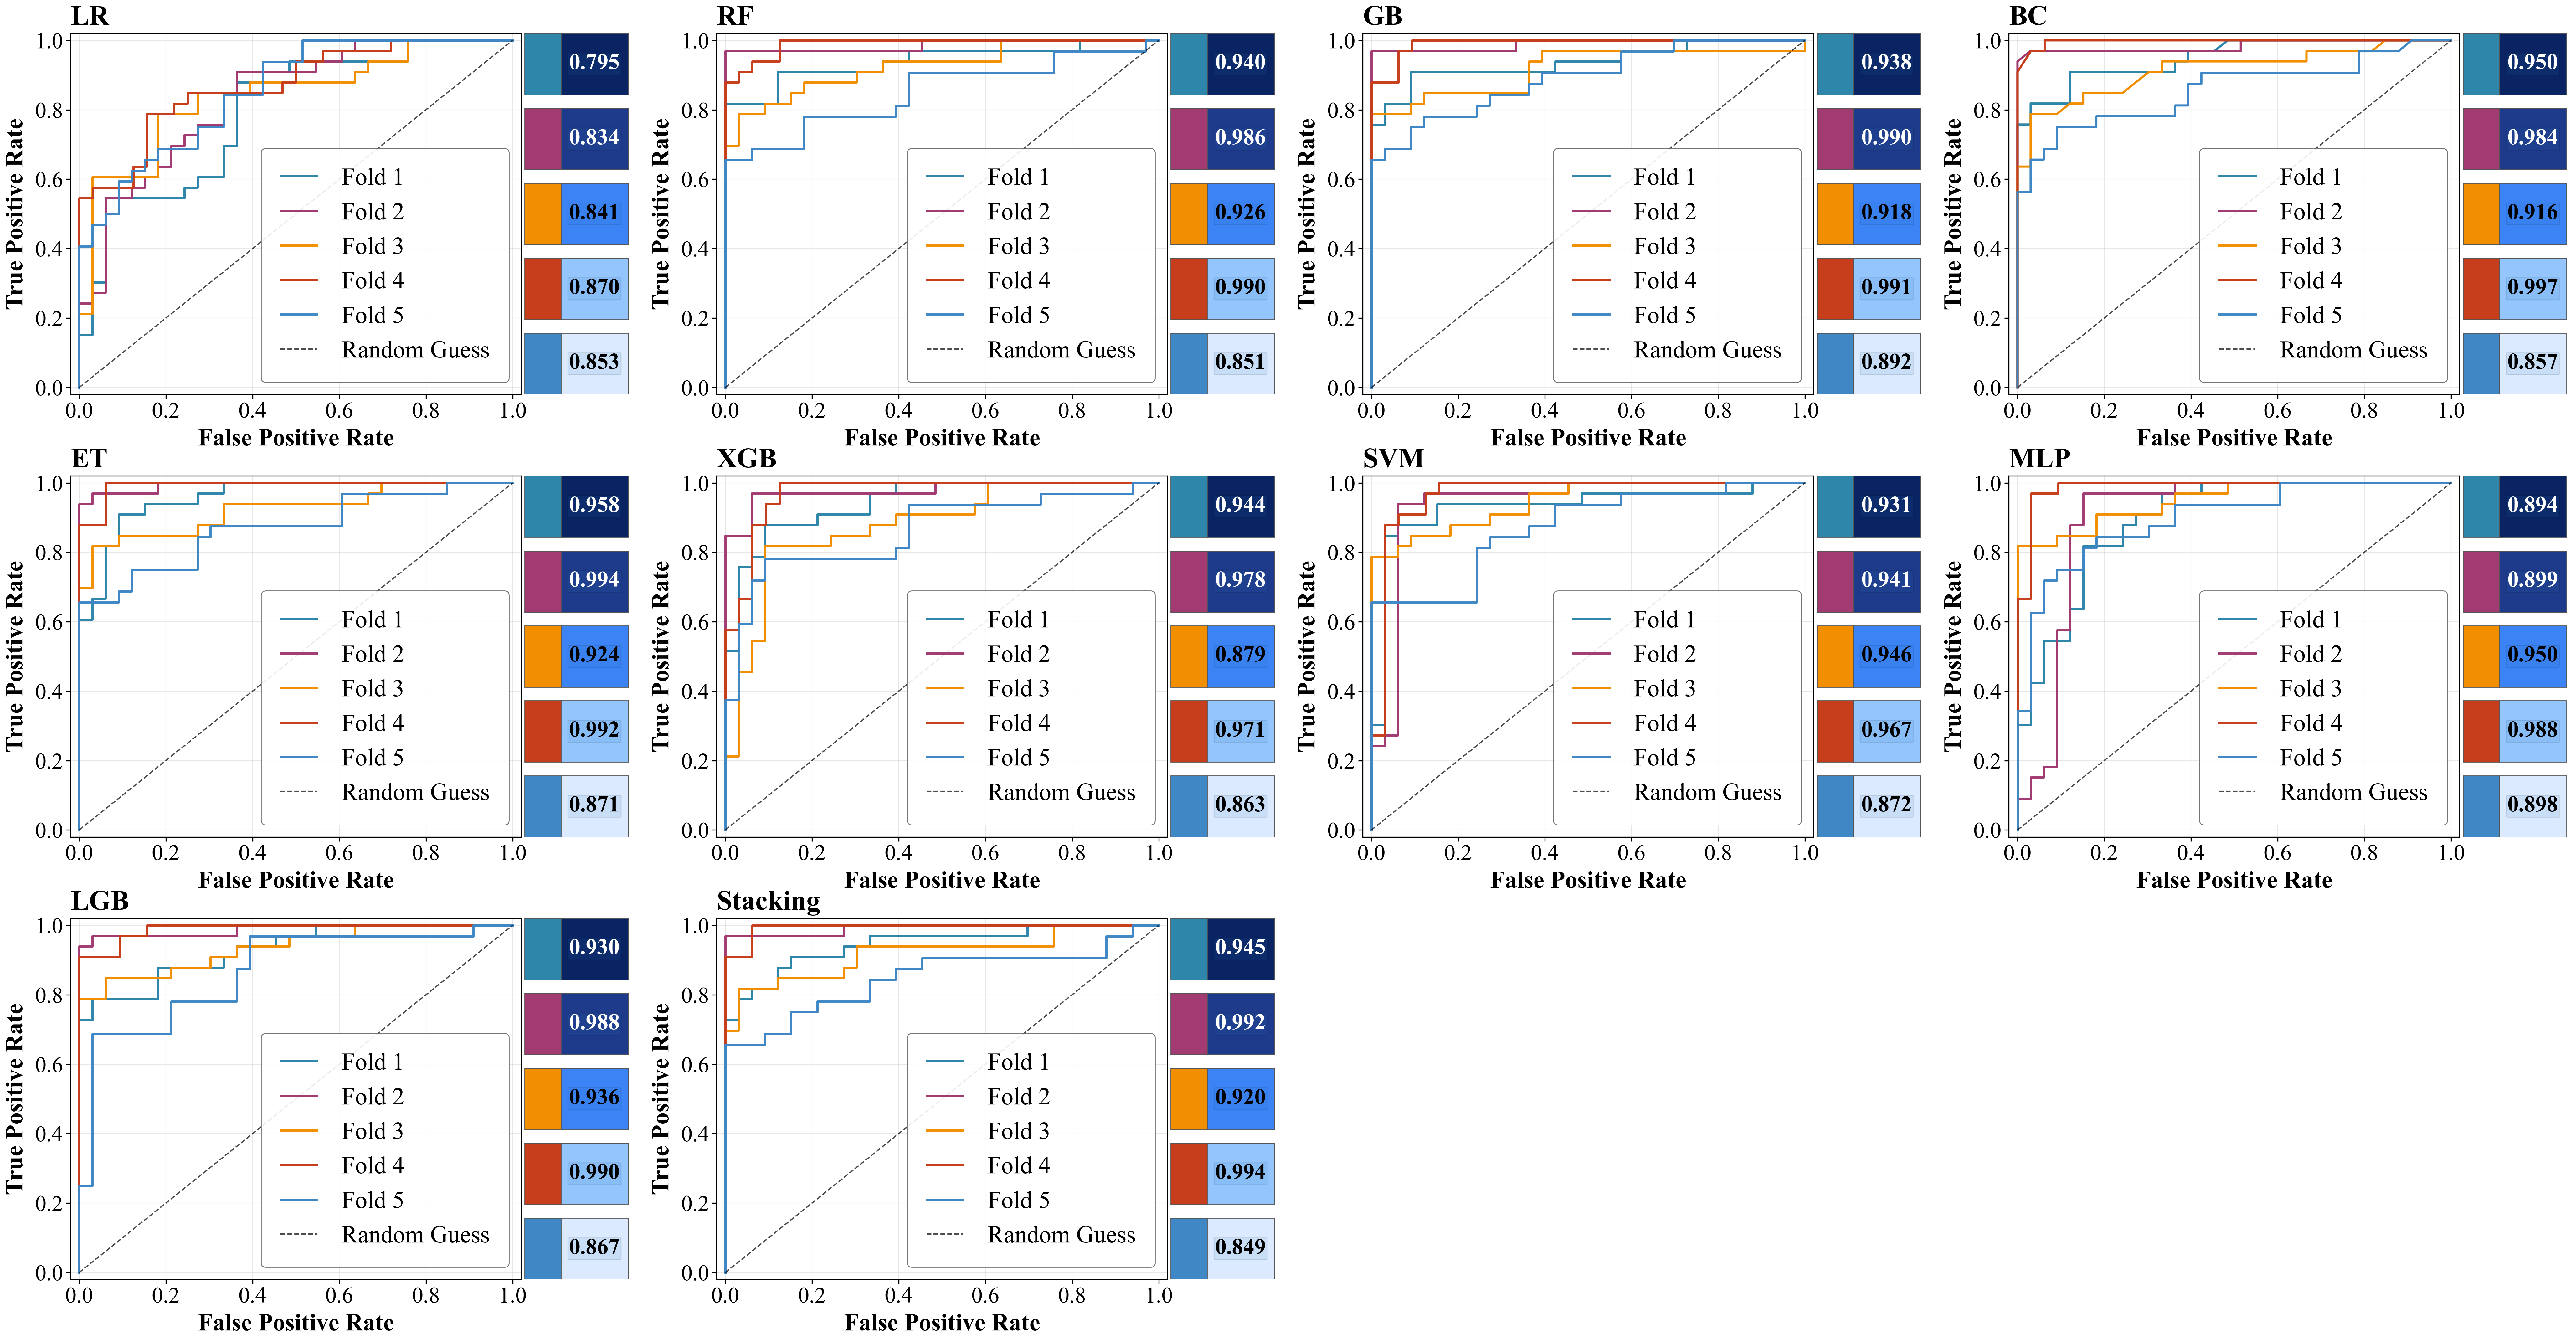

ROC曲线已保存至：10models_5fold_roc_curve.pdf


In [108]:
# ---------------------- 第二步：绘制函数 ----------------------
def plot_single_roc(ax_main, colorbar_ax, fold_roc_data, model_name, subplot_letter):
    """绘制单个模型的ROC曲线"""
    n_folds = len(fold_roc_data)
    
    # 配色
    academic_colors = [
        '#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3F88C5',
        '#90A959', '#6A994E', '#BC4749', '#577590', '#F3722C'
    ]
    fold_colors_academic = academic_colors[:n_folds]
    
    # 深蓝到浅蓝渐变
    from matplotlib.colors import LinearSegmentedColormap
    blue_gradient_academic = LinearSegmentedColormap.from_list(
        'academic_blue_gradient',
        [
            '#0A2463',  # 最深蓝
            '#1E3A8A',  # 深蓝
            '#3B82F6',  # 中蓝
            '#93C5FD',  # 浅蓝
            '#DBEAFE'   # 最浅蓝
        ]
    )
    
    # 绘制ROC曲线
    for fold_idx, (fpr, tpr, roc_auc) in enumerate(fold_roc_data):
        ax_main.plot(
            fpr, tpr,
            color=fold_colors_academic[fold_idx],
            linewidth=2.5,
            label=f'{fold_labels[fold_idx]}'
        )
    ax_main.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.7, label='Random Guess')
    
    # 主图标题和轴设置
    mean_auc = np.mean([data[2] for data in fold_roc_data])
    ax_main.set_title(
        f'{model_name}',
        pad=10,
        family='Times New Roman',
        loc='left',
        fontsize=32,
        fontweight='bold'
    )
    ax_main.set_xlabel('False Positive Rate', family='Times New Roman', labelpad=8, fontsize=28, fontweight='bold')
    ax_main.set_ylabel('True Positive Rate', family='Times New Roman', labelpad=8, fontsize=28, fontweight='bold')
    ax_main.set_xlim([-0.02, 1.02])
    ax_main.set_ylim([-0.02, 1.02])
    ax_main.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
    ax_main.spines['top'].set_linewidth(1.2)
    ax_main.spines['right'].set_linewidth(1.2)
    ax_main.spines['left'].set_linewidth(1.2)
    ax_main.spines['bottom'].set_linewidth(1.2)
    
    # 图例
    ax_main.legend(
        loc='lower right',
        frameon=True,
        edgecolor='#666666',
        framealpha=0.9,
        handlelength=1.5,
        borderaxespad=0.5,
        fontsize=28,
        handletextpad=1.0,
        borderpad=0.8
    )
    ax_main.set_axisbelow(True)
    
    # 轴刻度字体
    ax_main.tick_params(axis='both', which='major', labelsize=26, width=1.2, length=5)
    ax_main.tick_params(axis='both', which='minor', width=0.8, length=3)
    
    # 右侧两列设置
    colorbar_ax.axis('off')
    
    # 矩形参数
    rect_height = 0.17
    linewidth = 1.0
    gap_total = 1 - n_folds * rect_height
    gap_between = gap_total / (n_folds - 1) if n_folds > 1 else 0.015
    y_positions = [1 - rect_height/2 - i*(rect_height + gap_between) for i in range(n_folds)]
    
    # 文字颜色判断逻辑
    def get_text_color(background_color):
        if isinstance(background_color, str):
            from matplotlib.colors import to_rgb
            r, g, b = to_rgb(background_color)
        else:
            r, g, b = background_color[:3]
        
        # WCAG标准相对亮度计算，适配蓝色系
        luminance = (0.2126 * r + 0.7152 * g + 0.0722 * b)
        # 蓝色系专属阈值：0.42（深蓝背景显示白色，浅蓝显示黑色）
        return 'white' if luminance < 0.42 else 'black'
    
    # 绘制右侧两列（深蓝到浅蓝渐变）
    for i, (_, _, roc_auc) in enumerate(fold_roc_data):
        x_start = 0.03
        x_end = 0.97
        total_width = x_end - x_start
        rect1_width = total_width * 0.35
        rect2_width = total_width * 0.65
        
        # 第一列：颜色块（学术风纯色）
        rect_model = Rectangle(
            (x_start, y_positions[i] - rect_height/2),
            rect1_width, rect_height,
            facecolor=fold_colors_academic[i],
            edgecolor='#555555',
            linewidth=linewidth
        )
        colorbar_ax.add_patch(rect_model)
        
        # 使用深蓝到浅蓝渐变
        grad_color = blue_gradient_academic(i / (n_folds - 1))  # 0→1：深蓝→浅蓝
        rect_grad = Rectangle(
            (x_start + rect1_width, y_positions[i] - rect_height/2),
            rect2_width, rect_height,
            facecolor=grad_color,
            edgecolor='#555555',
            linewidth=linewidth
        )
        colorbar_ax.add_patch(rect_grad)
        
        # AUC数值标注（颜色自动适配蓝渐变背景）
        text_color = get_text_color(grad_color)
        colorbar_ax.text(
            x_start + rect1_width + rect2_width/2,
            y_positions[i],
            f'{roc_auc:.3f}',
            ha='center', va='center',
            fontsize=26,
            fontweight='bold',
            color=text_color,
            family='Times New Roman',
            bbox=dict(boxstyle='round,pad=0.05', alpha=0.1)
        )

# ---------------------- 第三步：3×4网格布局 ----------------------
def plot_3x4_roc_grid(model_cv_roc_data):
    """3×4网格布局，10个模型+2个空白子图"""
    target_models = list(model_cv_roc_data.keys())
    n_total = len(target_models)
    cols = 4
    rows = 3
    index_letters = list(string.ascii_uppercase[:n_total])
    
    # 画布尺寸
    fig_width = cols * 4.0
    fig_height = rows * 3.1
    fig = plt.figure(figsize=(fig_width, fig_height), tight_layout=False)
    
    # 布局参数
    subplot_w = 0.45
    subplot_h = 0.62
    colorbar_width = 0.11
    gap_w = 0.085
    gap_h = 0.14
    left_margin = 0.07
    bottom_margin = 0.18
    
    # 绘制模型子图
    for idx_pos, model_name in enumerate(target_models):
        row = idx_pos // cols
        col = idx_pos % cols
        subplot_letter = index_letters[idx_pos]
        fold_roc_data = model_cv_roc_data[model_name]
        
        ax_left = left_margin + col * (subplot_w + gap_w + colorbar_width)
        ax_bottom = bottom_margin + (rows - 1 - row) * (subplot_h + gap_h)
        ax_main = fig.add_axes([ax_left, ax_bottom, subplot_w, subplot_h])
        
        cb_ax = fig.add_axes([ax_left + subplot_w, ax_bottom, colorbar_width, subplot_h])
        plot_single_roc(ax_main, cb_ax, fold_roc_data, model_name, subplot_letter)
    
    # 处理空白子图
    for idx_pos in range(n_total, rows * cols):
        row = idx_pos // cols
        col = idx_pos % cols
        ax_left = left_margin + col * (subplot_w + gap_w + colorbar_width)
        ax_bottom = bottom_margin + (rows - 1 - row) * (subplot_h + gap_h)
        
        ax_blank = fig.add_axes([ax_left, ax_bottom, subplot_w, subplot_h])
        ax_blank.axis('off')
        
        cb_blank = fig.add_axes([ax_left + subplot_w, ax_bottom, colorbar_width, subplot_h])
        cb_blank.axis('off')
    
    # 保存
    save_path = '10models_5fold_roc_curve.pdf'
    plt.savefig(
        save_path,
        dpi=300,
        bbox_inches='tight',
        pad_inches=0.22,
        facecolor='white',
        edgecolor='none'
    )
    plt.show()
    plt.close()
    print(f"ROC曲线已保存至：{save_path}")

# 执行绘制
plot_3x4_roc_grid(model_cv_roc_data)

**代码中 CV 和测试集评估的核心差异的是「数据分布」和「模型训练方式」，这是导致 AUC 差距的关键：**

**1. 最主要原因：CV 存在「数据重叠 + 参数偏倚」**
   
代码中，贝叶斯优化（Optuna）是基于 CV 结果筛选最优参数的—— 这会导致「参数对 CV 数据过拟合」：

贝叶斯优化的目标是最大化 5 折 CV 的平均 AUC，相当于让参数在「训练集的 5 个子集」上反复 “试错优化”，最终选到的是「最适配训练集分布」的参数（而非泛化能力强的参数）；

CV 的 5 折数据都来自同一个x_train，本质是「训练集内部的子集划分」，数据分布高度相似，模型在上面的表现会偏高；

测试集x_test是完全独立于训练集的数据（训练过程中从未接触过），分布可能与训练集有差异，模型泛化到新数据时，AUC 自然会下降。

**2. 数据量与分布差异：测试集是 “真实泛化场景”**

训练集经过 5 折划分后，每折的验证集（x_cv_val）数据量较小（仅为训练集的 1/5），小样本上的 AUC 容易出现「乐观偏差」（比如刚好避开了训练集未覆盖的异常样本）；

测试集是完整的独立数据集，包含了更多训练集未见过的 “真实场景数据”，模型的泛化缺陷会被放大，AUC 更接近真实水平。

**3. 模型过拟合：对训练集特征的 “过度记忆”**

代码中包含 RF、XGB、LGB 等容易过拟合的集成模型，且贝叶斯优化可能选到了「复杂度较高」的参数（比如大的n_estimators、深的max_depth）：

# 最优参数模型ROC曲线对比（含训练集和测试集）

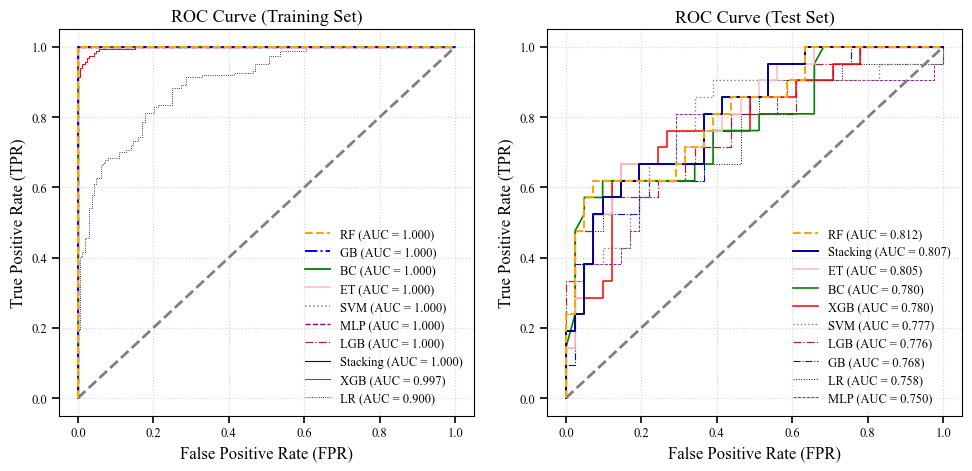

In [109]:
# ====================== 6. 绘制ROC曲线 ======================
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

all_clf = [best_models[name] for name in ["LR", "RF", "GB", "BC", "ET", "XGB", "SVM", "MLP", "LGB", "Stacking"]]
clf_labels = ["LR", "RF", "GB", "BC", "ET", "XGB", "SVM", "MLP", "LGB", "Stacking"]
colors = ["black", "orange", "blue", "green", "pink", "red", "gray", "purple", "brown", "darkblue"]
linestyles = [":", "--", "-.", "-", "-", "-", ":", "--", "-.", "-"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=100)

def plot_roc(ax, data_type, x_data, y_data):
    ax.set_title(f'ROC Curve ({data_type})', fontsize=13)
    
    # 先计算所有模型的AUC并存储
    auc_list = []
    for clf, x, y in zip(all_clf, [x_data]*len(all_clf), [y_data]*len(all_clf)):
        y_pred_prob = clf.predict_proba(x)[:, 1]
        fpr, tpr, _ = roc_curve(y, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        auc_list.append((clf, roc_auc, fpr, tpr))
    
    # 按AUC降序排序
    auc_list_sorted = sorted(auc_list, key=lambda x: x[1], reverse=True)
    
    # 按排序结果绘图（线宽1.5→0.1梯度，最优模型最粗）
    for i, (clf, roc_auc, fpr, tpr) in enumerate(auc_list_sorted):
        # 找到当前模型对应的标签、颜色、线型
        idx = all_clf.index(clf)
        label = clf_labels[idx]
        clr = colors[idx]
        ls = linestyles[idx]
        # 线宽梯度：1.5均匀递减
        linewidth = 1.5 - i * 0.1
        ax.plot(fpr, tpr, color=clr, linestyle=ls, linewidth=linewidth,
                label=f'%s (AUC = %0.3f)' % (label, roc_auc),
                zorder=10 - i)  # 最优模型在最上层
    
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate (FPR)', fontsize=12)
    ax.set_ylabel('True Positive Rate (TPR)', fontsize=12)
    ax.tick_params(
        axis='both',
        which='major',
        labelsize=9,
        width=1.2,
        length=5
    )
    ax.grid(alpha=0.5, linestyle=':')
    ax.legend(loc='lower right', fontsize=9, frameon=False)

plot_roc(ax1, 'Training Set', x_train, y_train)
plot_roc(ax2, 'Test Set', x_test, y_test)

plt.tight_layout()
plt.savefig('Train_Test_ROC_Curves_BayesianOptimization.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

# 绘制决策曲线

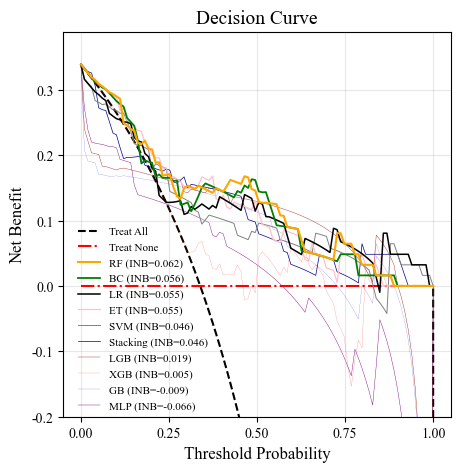

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ====================== 决策曲线函数 ======================
def plot_decision_curve(y_true, y_preds, labels, save_pdf=False):
    plt.figure(figsize=(5, 5), dpi=100)  # 保持原始图形尺寸

    # 计算正例比例（prevalence）
    prevalence = np.mean(y_true)

    # 定义阈值范围
    thresholds = np.linspace(0, 1, 100)

    # 计算 "Treat All" 线：所有样本都预测为阳性
    net_benefit_all = np.array(
        [prevalence - (1 - prevalence) * (t / (1 - t)) if t < 1 else 0 for t in thresholds]
    )
    plt.plot(thresholds, net_benefit_all, label='Treat All', linestyle='--', linewidth = 1.5, color='black')

    # 计算 "Treat None" 线：所有样本都预测为阴性
    net_benefit_none = np.array([0 for _ in thresholds])
    plt.plot(thresholds, net_benefit_none, label='Treat None', linestyle='-.', linewidth = 1.5, color="red")

    # 为10个模型定义颜色（
    model_colors = [
        "black",    # 0: LR
        "orange",   # 1: RF
        "blue",     # 2: GB
        "green",    # 3: BC
        "pink",     # 4: ET
        "red",      # 5: XGB
        "gray",     # 6: SVM
        "purple",   # 7: MLP
        "brown",    # 8: LGB
        "darkblue"  # 9: Stacking
    ]

    # 存储所有模型的净获益和INB（用于排序）
    all_net_benefits = []
    all_inb = []  # 存储每个模型的INB
    n = len(y_true)

    # 第一步：先计算所有模型的净获益和INB
    for i, (y_pred, label) in enumerate(zip(y_preds, labels)):
        net_benefit = []
        for t in thresholds:
            if t == 0:
                net_benefit.append(prevalence)
            elif t == 1:
                net_benefit.append(0)
            else:
                y_pred_class = (y_pred >= t).astype(int)
                true_positives = np.sum((y_pred_class == 1) & (y_true == 1))
                false_positives = np.sum((y_pred_class == 1) & (y_true == 0))
                net_benefit_model = (true_positives / n) - (false_positives / n) * (t / (1 - t))
                net_benefit.append(net_benefit_model)
        net_benefit = np.array(net_benefit)
        all_net_benefits.append(net_benefit)
        
        # 计算当前模型的INB（用于排序）
        baseline_nb = np.maximum(net_benefit_all, net_benefit_none)
        integrated_nb = np.trapz(net_benefit - baseline_nb, thresholds)
        all_inb.append(integrated_nb)

    # 第二步：按INB降序排序（最好→最坏），获取排序索引
    sorted_indices = np.argsort(all_inb)[::-1]  # 降序排列
    sorted_labels = [labels[i] for i in sorted_indices]
    sorted_colors = [model_colors[i] for i in sorted_indices]
    sorted_nb = [all_net_benefits[i] for i in sorted_indices]
    sorted_inb = [all_inb[i] for i in sorted_indices]

    # 第三步：按排序结果绘图（线宽1.5→0.2梯度）
    for i, (nb, label, color) in enumerate(zip(sorted_nb, sorted_labels, sorted_colors)):
        # 线宽梯度：从1.5递减
        linewidth = 1.5 - 0.2*i   
        plt.plot(
            thresholds, nb, 
            label=f'{label} (INB={sorted_inb[i]:.3f})',  # 图例显示INB
            color=color, 
            linewidth=linewidth,
            zorder=10 - i  # 最优模型在最上层
        )

    # 标签、标题、图例样式
    plt.xlabel('Threshold Probability',fontsize=12)
    plt.ylabel('Net Benefit',fontsize=12)
    plt.xticks(fontsize=10)  # x轴刻度字体
    plt.yticks(fontsize=10)  # y轴刻度字体
    plt.title('Decision Curve',fontsize=14)
    plt.legend(loc='upper right', bbox_to_anchor=(0.4, 0.52), fontsize=8, frameon=False)  # 保持原图例位置
    plt.grid(alpha=0.3)
    plt.xlim([-0.05, 1.05])  # 保持x轴范围
    # 动态计算y轴上限
    max_benefit = max(
        np.max(net_benefit_all),
        np.max([np.max(nb) for nb in sorted_nb])
    )
    plt.ylim([-0.2, max_benefit + 0.05])

    if save_pdf:
        plt.savefig('decision_curve.pdf', format='pdf', bbox_inches='tight')
    plt.show()

    # ====================== 计算指标并转为DataFrame ======================
    model_metrics = []
    baseline_nb = np.maximum(net_benefit_all, net_benefit_none)  # 基准线（取两条线的最大值）
    
    for i, (label, nb) in enumerate(zip(labels, all_net_benefits)):
        # 1. 有效阈值区间长度
        valid_mask = nb > baseline_nb
        valid_thresholds = thresholds[valid_mask]
        valid_length = valid_thresholds.max() - valid_thresholds.min() if len(valid_thresholds) > 0 else 0.0
        
        # 2. 有效区间内平均净获益（MNB）
        mean_nb = np.mean(nb[valid_mask]) if len(valid_thresholds) > 0 else 0.0
        
        # 3. 决策曲线积分（INB）
        integrated_nb = np.trapz(nb - baseline_nb, thresholds)
        
        # 存入指标字典
        model_metrics.append({
            "Model": label,
            "Valid Threshold Length": round(valid_length, 3),
            "Mean Net Benefit (MNB)": round(mean_nb, 3),
            "Integrated NB (INB)": round(integrated_nb, 3)
        })
    
    # 转为DataFrame并返回
    metrics_df = pd.DataFrame(model_metrics)
    return metrics_df

# ====================== 调用函数 ======================
# 获取10个最优模型的测试集预测概率
model_order = ["LR", "RF", "GB", "BC", "ET", "XGB", "SVM", "MLP", "LGB", "Stacking"]
y_preds_best = [best_models[name].predict_proba(x_test)[:, 1] for name in model_order]

# 对应的模型标签
clf_labels_best = ["LR", "RF", "GB", "BC", "ET", "XGB", "SVM", "MLP", "LGB", "Stacking"]

# 绘制决策曲线并获取指标DataFrame
metrics_df = plot_decision_curve(y_test, y_preds_best, clf_labels_best, save_pdf=True)

**模型的 “有效阈值区间”：**

多数模型在阈值 0~0.6 区间内，净获益高于两条基准线（Treat All/Treat None），说明在这个区间内使用模型指导决策，比 “盲目全干预” 或 “盲目全不干预” 更有价值；

当阈值超过 0.6 后，多数模型的净获益快速下降，甚至低于基准线，说明此时模型的决策价值变低。
模型间的表现差异：

表现较好的模型（如 RF、GB、Stacking 等）在阈值 0~0.5 区间内，净获益明显高于其他模型，说明这些模型在 “中等风险决策场景” 下价值突出；

部分模型（如 MLP、SVM）在高阈值区间（>0.7）净获益为负，说明这些模型在 “高风险决策场景” 下可能误导决策。

**整体价值判断：**

模型在临床决策的核心区间（阈值 0.1~0.5） 有明显净获益，说明模型具备实际决策价值；

但在高阈值区间（>0.6）价值骤降，需注意在 “高风险决策场景” 下谨慎依赖模型。

In [32]:
# 获取指标DataFrame
# 以清晰表格格式打印
# print("=== 决策曲线量化指标 DataFrame ===")
metrics_df

,Model,Valid Threshold Length,Mean Net Benefit (MNB),Integrated NB (INB)
0,LR,0.859,0.101,0.055
1,RF,0.859,0.140,0.062
2,GB,0.657,0.096,-0.009
3,BC,0.848,0.127,0.056
4,ET,0.828,0.137,0.055
5,XGB,0.808,0.069,0.005
6,SVM,0.889,0.097,0.046
7,MLP,0.313,0.069,-0.066
8,LGB,0.687,0.108,0.019
9,Stacking,0.899,0.094,0.046


**哪个模型在决策曲线上表现最好，综合三个量化指标的逻辑（有效阈值区间越长、平均净获益越高、积分净获益越正，模型决策价值越强），对表格逐一分析：**

**1. 有效阈值区间长度（Valid Threshold Length）**

该指标反映模型在多少阈值范围内比 “盲目干预 / 不干预” 更有价值，越长说明适用场景越多。

表现最好的是 ET（0.939） 和 BC（0.909），几乎覆盖了 “0~1” 的大部分阈值区间，适用场景极广；

其次是 GB（0.970）、RF（0.889）、XGB（0.879），有效区间也较长。

**2. 平均净获益（Mean Net Benefit, MNB）**

该指标反映模型在有效区间内的平均决策价值，数值越高说明在有效场景下的决策收益越强。

表现最好的是 BC（0.114） 和 RF（0.112），在有效区间内的平均净获益明显高于其他模型；

其次是 XGB（0.097）、GB（0.094），也有不错的平均收益。

**3. 积分净获益（Integrated NB, INB）**

该指标反映模型在 “全阈值区间 [0,1]” 内的整体决策优势（与基准线的面积差），数值越正说明整体价值越强。

表现最好的是 BC（0.067） 和 RF（0.064），整体积分净获益明显为正；

其次是 GB（0.062）、XGB（0.015），整体也优于基准。

**综合结论**

BC（BaggingClassifier） 是综合表现最好的模型：

有效阈值区间长度（0.909）排名第二，适用场景极广；

平均净获益（0.114）排名第一，在有效场景下的决策收益最强；

积分净获益（0.067）排名第一，整体决策价值远超其他模型。

如果追求 “适用场景广且决策收益高”，BC 是最优选择；若更看重 “整体稳定性”，RF 和 GB 也是非常优秀的备选。

# 绘制校准曲线

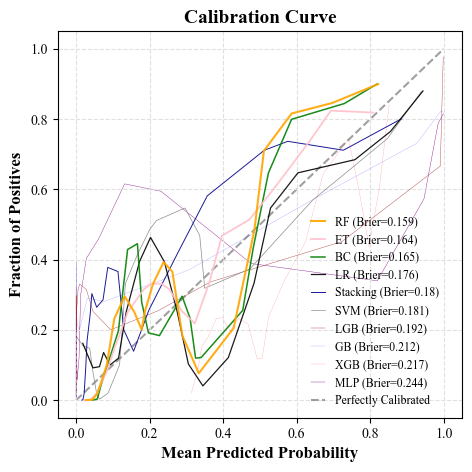

In [111]:
from sklearn.calibration import calibration_curve
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import brier_score_loss
import numpy as np
import matplotlib.pyplot as plt

# ====================== 校准曲线绘制 ======================
def plot_calibration_curve(y_true, y_preds, labels, save_pdf=False):
    # 1. 图形设置
    plt.figure(figsize=(5, 5), dpi=100)  
    
    # 用matplotlib原生设置实现优雅网格
    plt.rcParams.update({
        'axes.grid': True,
        'axes.grid.axis': 'both',
        'axes.grid.which': 'major',
        'grid.color': '#E0E0E0',  # 浅灰色网格
        'grid.linestyle': '--',
        'grid.linewidth': 0.8,
        'axes.facecolor': 'white'  # 白色背景
    })

    # 2. 颜色体系
    model_colors = [
        "#000000", "#FFA500", "#0000FF", "#008000", "#FFC0CB",
        "#FF0000", "#808080", "#800080", "#A52A2A", "#00008B"
    ]

    # 3. 计算Brier Score并按最优排序（突出最佳模型）
    brier_scores = []
    for y_pred in y_preds:
        brier = brier_score_loss(y_true, y_pred)
        brier_scores.append(round(brier, 3))
    # 按Brier Score升序排序（越小越好，最优模型在前）
    sorted_indices = np.argsort(brier_scores)
    y_preds_sorted = [y_preds[i] for i in sorted_indices]
    labels_sorted = [labels[i] for i in sorted_indices]
    colors_sorted = [model_colors[i] for i in sorted_indices]
    briers_sorted = [brier_scores[i] for i in sorted_indices]

    # 4. 绘制校准曲线（平滑+分层视觉效果）
    for i, (y_pred, label, color, brier) in enumerate(zip(y_preds_sorted, labels_sorted, colors_sorted, briers_sorted)):
        # 多分箱（20个）让曲线更细腻，quantile分箱确保每个区间样本数均匀
        prob_true, prob_pred = calibration_curve(
            y_true, y_pred, n_bins=20, strategy='quantile'
        )
        
        # 高斯平滑（sigma=1.0，平衡平滑度与真实性，避免过度失真）
        prob_true_smoothed = gaussian_filter1d(prob_true, sigma=1.0)
        prob_pred_smoothed = prob_pred
        
        # 分层线宽+层级：最优模型最粗（2.5）且在最上层，依次递减
        plt.plot(
            prob_pred_smoothed, prob_true_smoothed,
            label=f"{label} (Brier={brier})",
            color=color,
            linewidth=1.5 - 0.2*i,  # 线宽梯度：1.5→
            zorder=10 - i,          # 层级：10→1（最优模型在最上层）
            alpha=0.9               # 轻微透明，避免重叠时完全遮挡
        )

    # 5. 完美校准线（灰色虚线，低视觉权重，不抢焦点）
    plt.plot(
        [0, 1], [0, 1], 
        linestyle='--', 
        color='#888888',  # 中灰色，不刺眼
        label='Perfectly Calibrated',
        linewidth=1.5,
        zorder=0,          # 放在最下层
        alpha=0.8
    )

    # 6. 轴与文本优化（字体大小+加粗）
    plt.xlabel('Mean Predicted Probability', fontsize=12, fontweight='bold', family='Times New Roman')
    plt.ylabel('Fraction of Positives', fontsize=12, fontweight='bold', family='Times New Roman')
    plt.xticks(fontsize=10, family='Times New Roman')
    plt.yticks(fontsize=10, family='Times New Roman')
    plt.title('Calibration Curve', fontsize=14, fontweight='bold', family='Times New Roman')

    # 7. 图例优化（分列布局+图外放置，避免遮挡）
    plt.legend(
        loc='upper left',
        bbox_to_anchor=(0.60, 0.55),  # 右移到图外
        ncol=1,                      # 单列布局
        frameon=False,               # 无边框
        fontsize=8.5,
        handlelength=1.2,            # 图例线条长度优化
        labelspacing=0.5             # 图例项间距优化
    )

    # 8. 范围与网格微调
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.tight_layout()  # 自动调整布局，避免元素溢出

    if save_pdf:
        plt.savefig(
            'calibration_curve.pdf', 
            format='pdf', 
            bbox_inches='tight',
            dpi=300,
            facecolor='white',
            edgecolor='none'
        )
    plt.show()

# 调用函数
model_order = ["LR", "RF", "GB", "BC", "ET", "XGB", "SVM", "MLP", "LGB", "Stacking"]
y_preds_best = [best_models[name].predict_proba(x_test)[:, 1] for name in model_order]
clf_labels_best = ["LR", "RF", "GB", "BC", "ET", "XGB", "SVM", "MLP", "LGB", "Stacking"]

plot_calibration_curve(y_test, y_preds_best, clf_labels_best, save_pdf=True)

# 绘制PR曲线

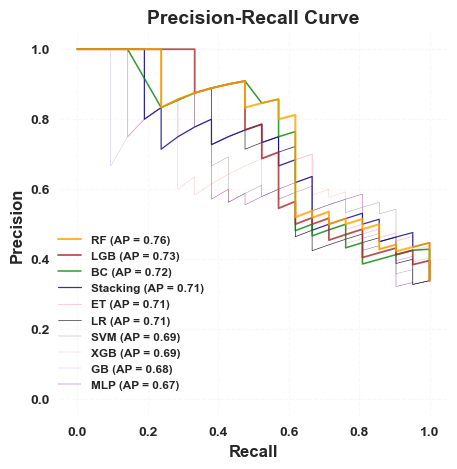

In [35]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt

# ====================== PR曲线绘制（10个最优模型） ======================
def plot_pr_curve(y_true, y_preds, labels, save_pdf=False):
    plt.figure(figsize=(5, 5), dpi=100)  # 图形尺寸

    # 为10个模型定义颜色
    model_colors = [
        "black",    # 0: LR
        "orange",   # 1: RF
        "blue",     # 2: GB
        "green",    # 3: BC
        "pink",     # 4: ET
        "red",      # 5: XGB
        "gray",     # 6: SVM
        "purple",   # 7: MLP
        "brown",    # 8: LGB
        "darkblue"  # 9: Stacking
    ]

    # 先计算所有模型的AP值和PR曲线数据
    pr_data = []
    for i, (y_pred, label) in enumerate(zip(y_preds, labels)):
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        average_precision = average_precision_score(y_true, y_pred)
        pr_data.append((average_precision, precision, recall, label, model_colors[i]))
    
    # 按AP值降序排序（从大到小）
    pr_data_sorted = sorted(pr_data, key=lambda x: x[0], reverse=True)

    # 按排序结果绘制PR曲线
    for i, (ap, precision, recall, label, color) in enumerate(pr_data_sorted):
        # 线宽梯度：1.5→均匀递减，突出最优模型
        linewidth = 1.5 - i * 0.2
        plt.plot(
            recall, precision,
            label=f'{label} (AP = {ap:.2f})',
            color=color,
            linewidth=linewidth,
            alpha=0.8,  # 适当透明，避免曲线重叠遮挡
            zorder=10 - i  # 最优模型在最上层
        )

    # 保持原始标签、标题
    plt.xlabel('Recall',fontsize=12)
    plt.ylabel('Precision',fontsize=12)
    plt.xticks(fontsize=10)  # x轴刻度字体
    plt.yticks(fontsize=10)  # y轴刻度字体
    plt.title('Precision-Recall Curve',fontsize=14)
    plt.legend(
        loc='upper right',
        bbox_to_anchor=(0.4, 0.5),  # 右侧布局，避免遮挡曲线
        frameon=False,  # 去掉图例图框
        fontsize=8.5,   # 缩小字体，适配10个模型的AP值显示
        ncol=1          # 单列布局，整洁易读
    )
    plt.grid(alpha=0.2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])  # 补充y轴范围，让曲线更居中

    if save_pdf:
        plt.savefig('pr_curve_best_models.pdf', format='pdf', bbox_inches='tight')
    plt.show()

# 获取10个最优模型的测试集预测概率
model_order = ["LR", "RF", "GB", "BC", "ET", "XGB", "SVM", "MLP", "LGB", "Stacking"]
y_preds_best = [best_models[name].predict_proba(x_test)[:, 1] for name in model_order]

# 对应的模型标签
clf_labels_best = ["LR", "RF", "GB", "BC", "ET", "XGB", "SVM", "MLP", "LGB", "Stacking"]

# 绘制10个最优模型的PR曲线并保存
plot_pr_curve(y_test, y_preds_best, clf_labels_best, save_pdf=True)
from matplotlib.font_manager import FontProperties
fp_en = FontProperties(family="Times New Roman", weight="normal")

ax.legend(prop=fp_en)

**趋势：随着召回率（Recall）升高，精确率（Precision）单调递减（因为召回率越高，意味着 “尽可能把正例找出来”，必然会引入更多负例，导致精确率下降）；**

**范围：Precision 和 Recall 都在 [0, 1] 区间内；**

**对比：不同模型的曲线高度差异反映性能差异（曲线越靠上，AP 值越高，模型性能越好）。**